# Jai kisan Neo Bank - Logistic Regression

**Introduction**

Jai Kisan is a rural-focused fintech that aims to bridge the credit gap in the rural market. Currently, 80% of rural individuals and businesses find it difficult to access formal credit and the data science team at Jai Kisan is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

Jai Kisan deploys formal credit in the rural economy via two main financial instruments:

    Buy Now, Pay Later: Where a customer can avail credit at the point of sale to purchase goods.
    Supply Chain Financing: Where a business (partnered with Jai Kisan) can finance invoices and/or purchase orders to bridge the gap in payable and receivable credit cycles.

This case study will focus on the underwriting process behind Supply Chain Financing.


**Problem Statement**

Given a set of attributes for an MSME/ Individual, determine if a credit line should be extended to a business. If so, what should the repayment terms be in business recommendations?

We have target variable '**loan_status**' which indicates which businesses whom we have lend money in the past have defaulted or paid the amount.
We can use the given historic data to create groups of businesses who are risky and might have high default ratio and we should consider if to lend money to them or not prudently.

To be specific we want to do following:
1. Create groups of risky and non-risky cases
2. Find features which are affecting default ratio

In [374]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [375]:
data = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/043/original/jai_kisan_logistic_regression.csv')

data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [376]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'],format='%b-%Y')
data['issue_d'] = pd.to_datetime(data['issue_d'],format='%b-%Y')

In [377]:
y = data['loan_status']
X = data.drop(['loan_status'],axis=1)

In [378]:
X['issue_d_month'] = X['issue_d'].dt.month
X['earliest_cr_line_month'] = X['issue_d'].dt.month
X['issue_d_qtr'] = X['issue_d'].dt.quarter
X['earliest_cr_line_qtr'] = X['issue_d'].dt.quarter

X = data.drop(['issue_d','earliest_cr_line'],axis=1)

In [379]:
sub_g = {j:i for i,j in enumerate(np.sort(X['sub_grade'].unique()))}
gg = {j:i for i,j in enumerate(np.sort(X['grade'].unique()))}
emp_lg = {'10+ years':11, '4 years':5, '< 1 year':1, '6 years':7, '9 years':10,
       '2 years':3, '3 years':4, '8 years':9, '7 years':8, '5 years':6, '1 year':2,np.nan:0}
home_g = {j:i for i,j in enumerate(np.sort(X['home_ownership'].unique()))}
term_g = {' 36 months':0, ' 60 months':1}

In [380]:
X['term'] = X['term'].replace(term_g)
X['grade'] = X['grade'].replace(gg)
X['sub_grade'] = X['sub_grade'].replace(sub_g)
X['emp_length'] = X['emp_length'].replace(emp_lg)
X['initial_list_status'] = X['initial_list_status'].replace({'w':1,'f':0})
X['home_ownership'] = X['home_ownership'].replace(home_g)

In [381]:
dh = ['verification_status','purpose','application_type']
jk =[]
for k in dh:
 
  jk.append(pd.get_dummies(X[k]))
  X.drop([k],axis=1,inplace=True)

In [382]:
X.drop(['emp_title','title','address'],inplace=True,axis=1)

In [383]:
X = pd.concat([X] + jk,axis=1)

In [384]:
X.drop(['loan_status'],axis=1,inplace=True)

In [385]:
def create_fix_nan(df,col):
    df[col+'_na'] = df[col].isna()
    df.loc[df[col].isna(),col] = df[col].value_counts().head().index[0]
    #print(df[col].value_counts().head().index[0])
    print(df[col].isna().sum())
    return df
    
X = create_fix_nan(X,'revol_util')
X = create_fix_nan(X,'mort_acc')
X = create_fix_nan(X,'pub_rec_bankruptcies')

0
0
0


In [386]:
tmp =data['loan_status'].value_counts().reset_index()

ratio = round(tmp.loc[1,'loan_status']/tmp.loc[0,'loan_status'],2)

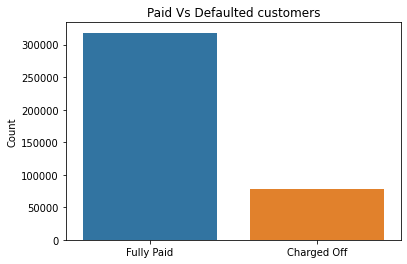

In [387]:
sns.barplot(data =tmp ,x = 'index', y='loan_status')
plt.title('Paid Vs Defaulted customers')
plt.xlabel(None)
plt.ylabel('Count')
plt.show()

In [388]:
print("The ratio of people who defaulted vs those who fully paid in population is",ratio )

The ratio of people who defaulted vs those who fully paid in population is 0.24


**In our analysis we will find groups where ratio is higher than 0.24 and mark those categories as risky, otherwise not risky.**

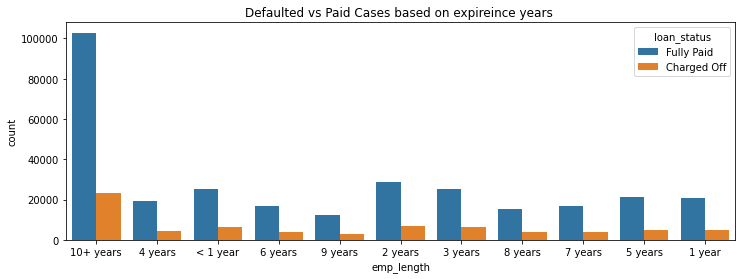

In [389]:
plt.figure(figsize=(12,4))
order = list(data['emp_length'].dropna().unique())

sns.countplot(x='emp_length',data=data, order=order,hue='loan_status')
plt.title('Defaulted vs Paid Cases based on expireince years ')
plt.show()

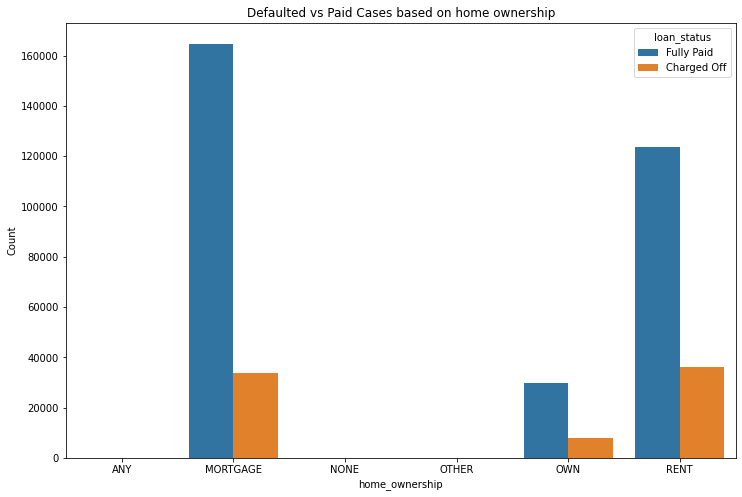

In [390]:
plt.figure(figsize=(12,8))
tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby(['home_ownership','loan_status']).count()['Count'].reset_index()
sns.barplot(data=tmp,x='home_ownership',y='Count',hue='loan_status')
plt.title('Defaulted vs Paid Cases based on home ownership')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


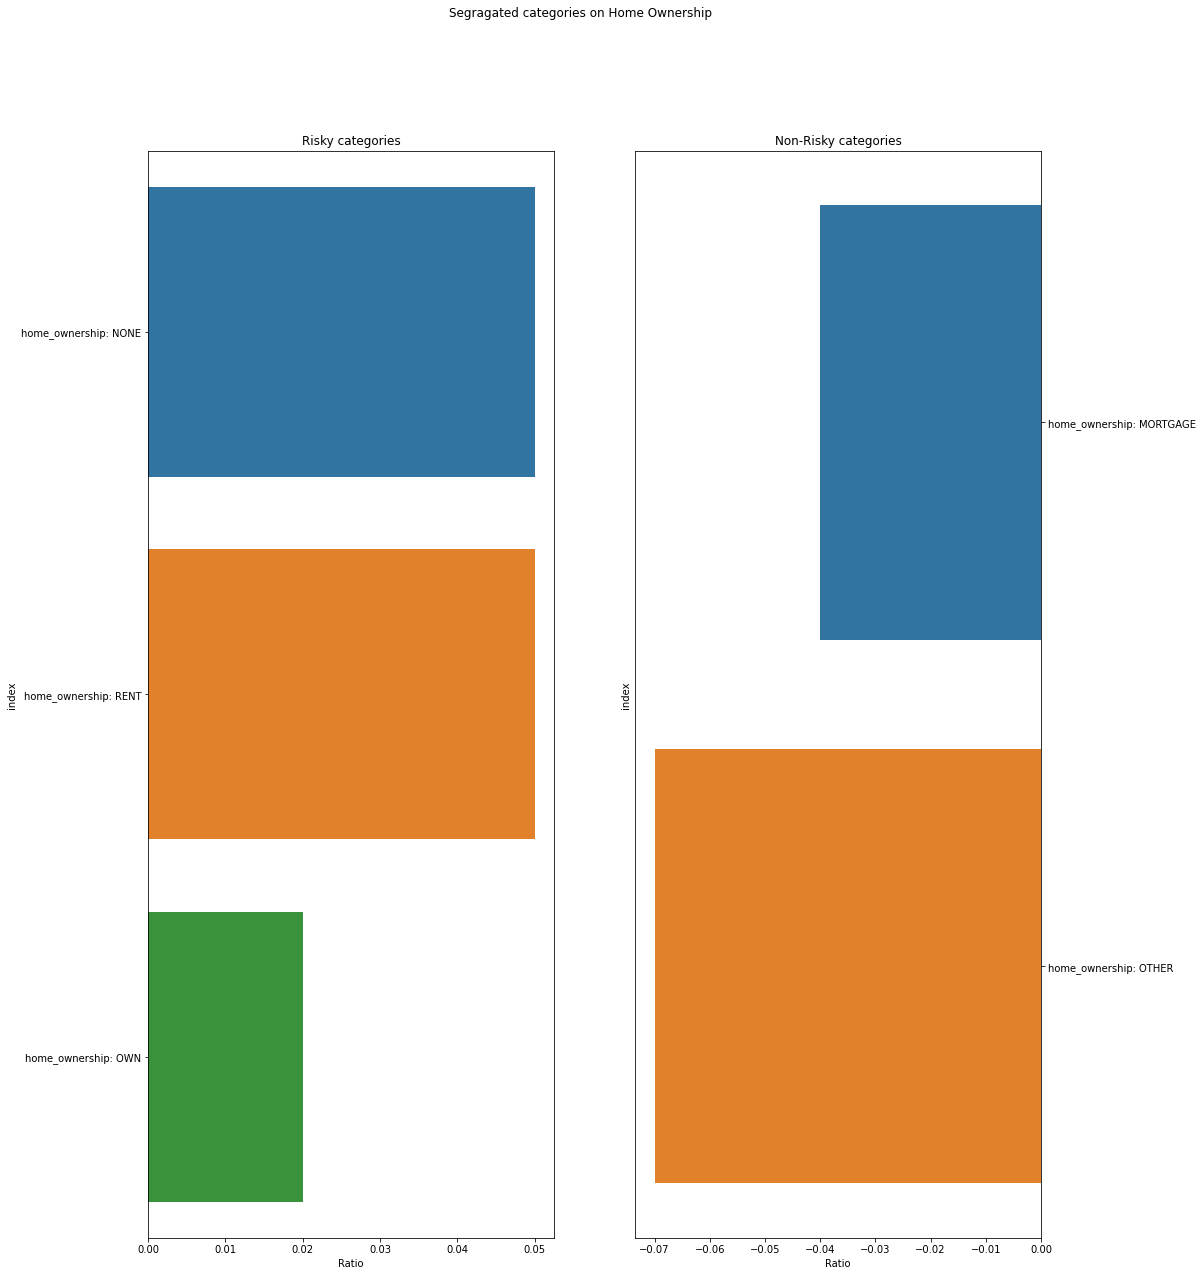

In [391]:
feat1 = 'home_ownership'
tmp = data.copy()

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Home Ownership')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

* customers who do not own a house or are living on rent are most risky
* customers in category "OTHER" are least risky

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


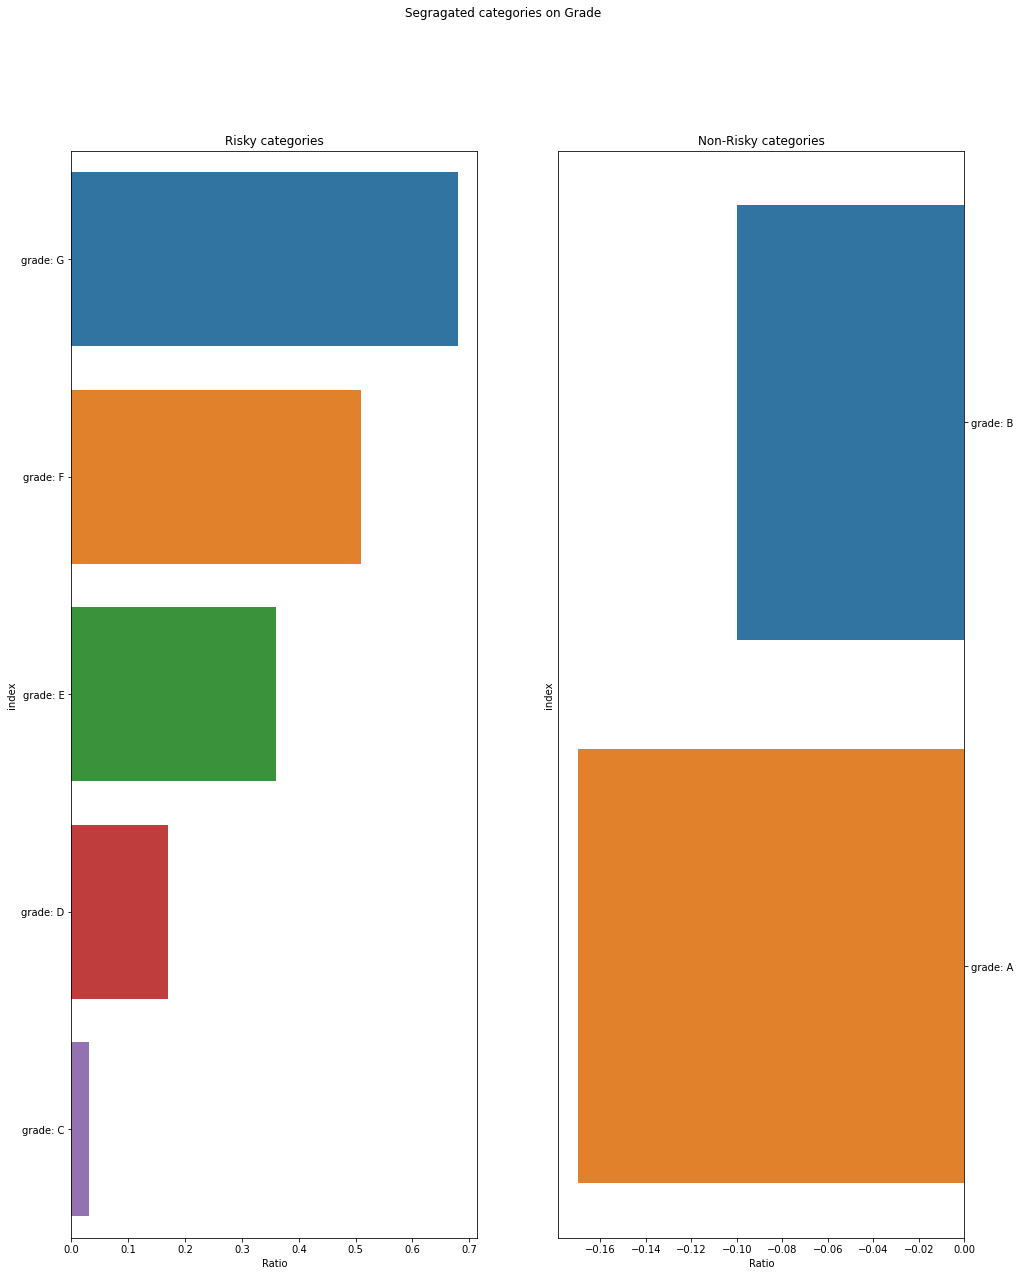

In [392]:
feat1 = 'grade'
tmp = data.copy()

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Grade')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

* customers who belong to grades D,E,F and G are most risky
* customers in grade A and B are least risky

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


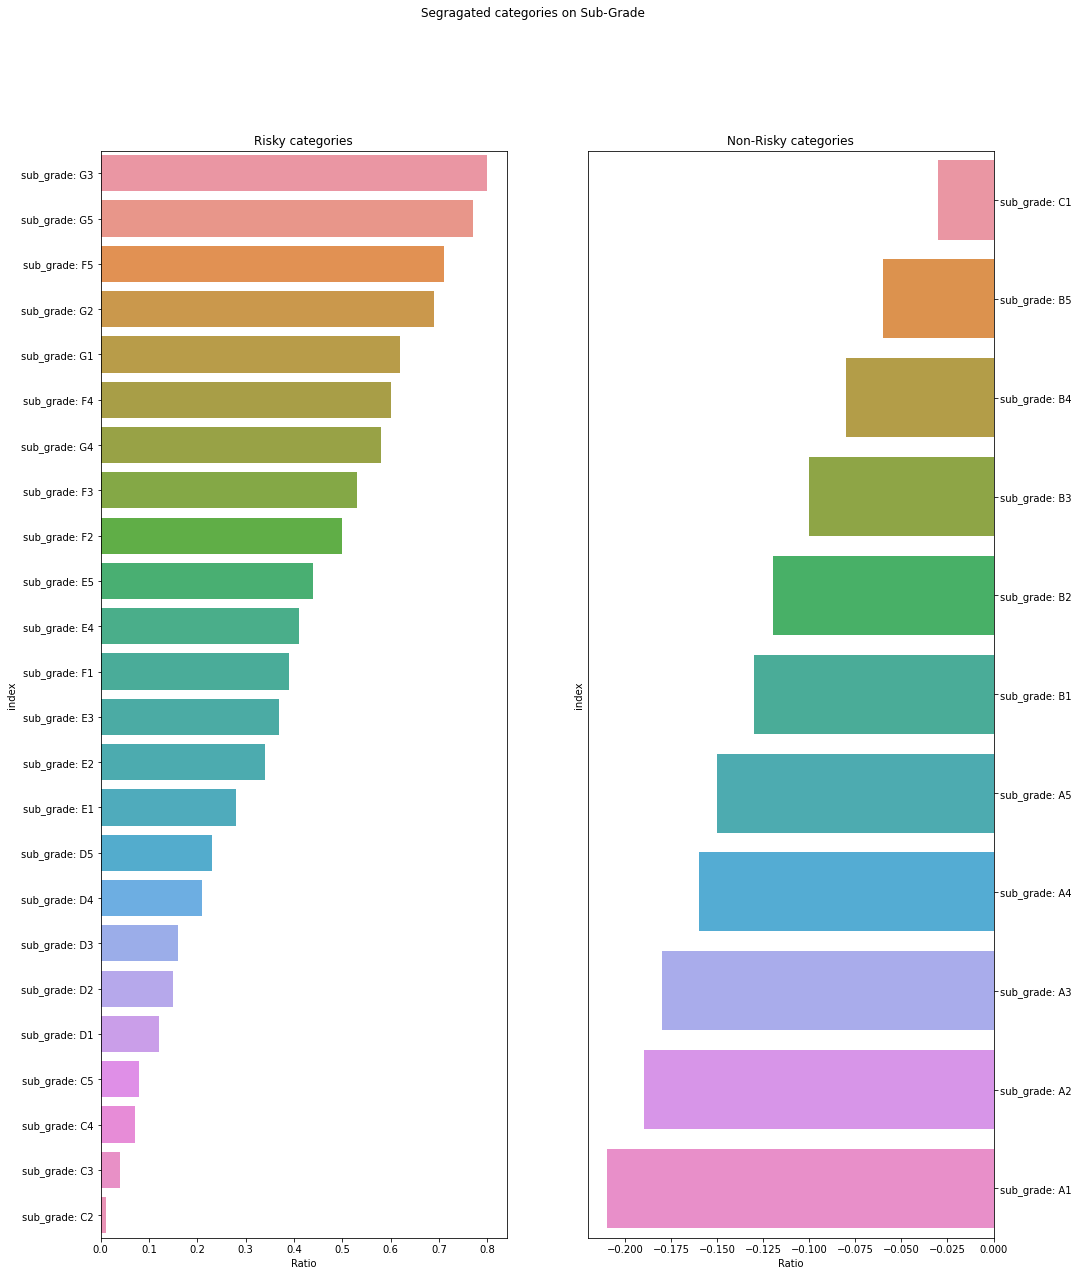

In [393]:
feat1 = 'sub_grade'
tmp = data.copy()

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Sub-Grade')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


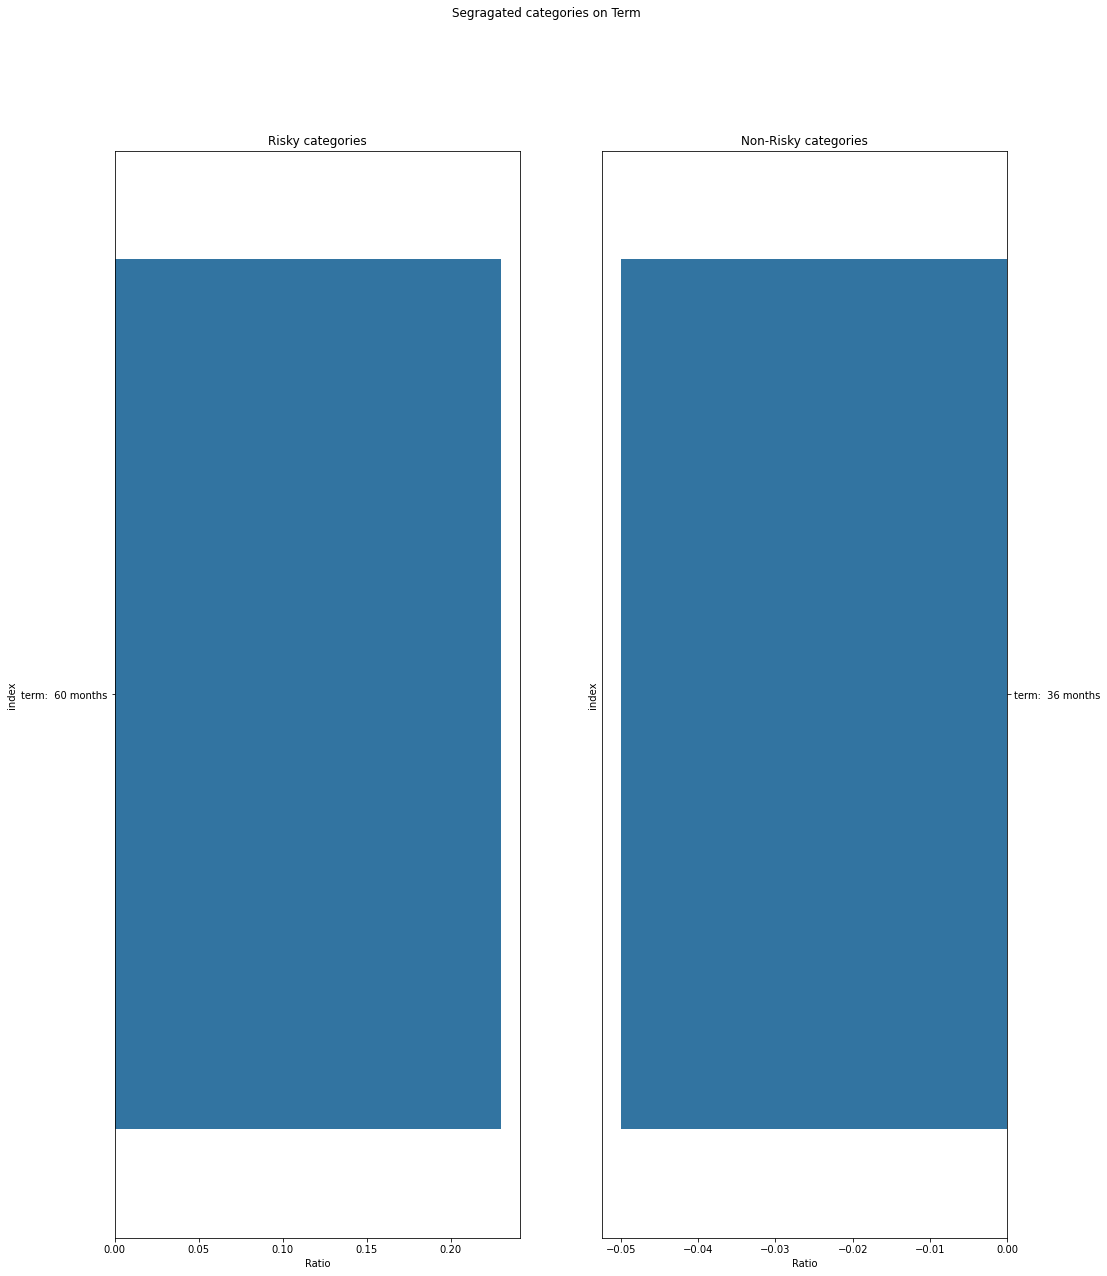

In [394]:
feat1 = 'term'
tmp = data.copy()

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Term')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

<AxesSubplot:>

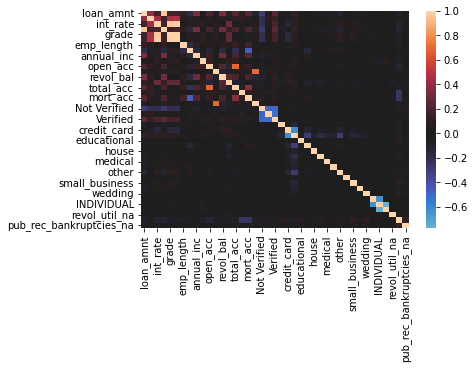

In [395]:
tmp = pd.concat([X,y],axis=1)
tmp['loan_status'] = tmp['loan_status'].replace({'Fully Paid':0,'Charged Off':1})

tmp = pd.concat([X,y],axis=1)
sns.heatmap(tmp.corr(), center=0)

In [396]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [397]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(np.array(X.sample(frac=0.1,random_state=101), dtype=float)
, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,60.827788,loan_amnt
1,6.901600,term
2,23.880224,int_rate
3,52.889443,installment
4,22.523942,grade
5,45.105733,sub_grade
6,1.062739,emp_length
7,1.359311,home_ownership
8,1.333454,annual_inc
9,1.348063,dti


In [398]:
X.drop(['loan_amnt','installment','sub_grade'],axis=1,inplace=True)

In [399]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(np.array(X.sample(frac=0.1,random_state=101), dtype=float)
, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.417600,term
1,12.026117,int_rate
2,11.715257,grade
3,1.059014,emp_length
4,1.356839,home_ownership
5,1.258750,annual_inc
6,1.340354,dti
7,2.146535,open_acc
8,2.206168,pub_rec
9,1.239042,revol_bal


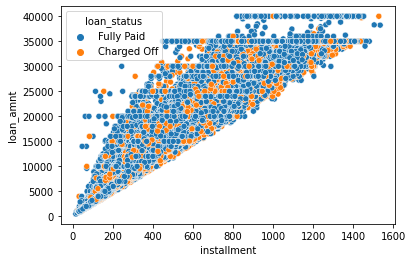

In [400]:
sns.scatterplot(data=tmp,x='installment',y='loan_amnt',hue='loan_status')
plt.show()

For vacation
Yes

No
Grade B, A, C, D,F, G (All)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


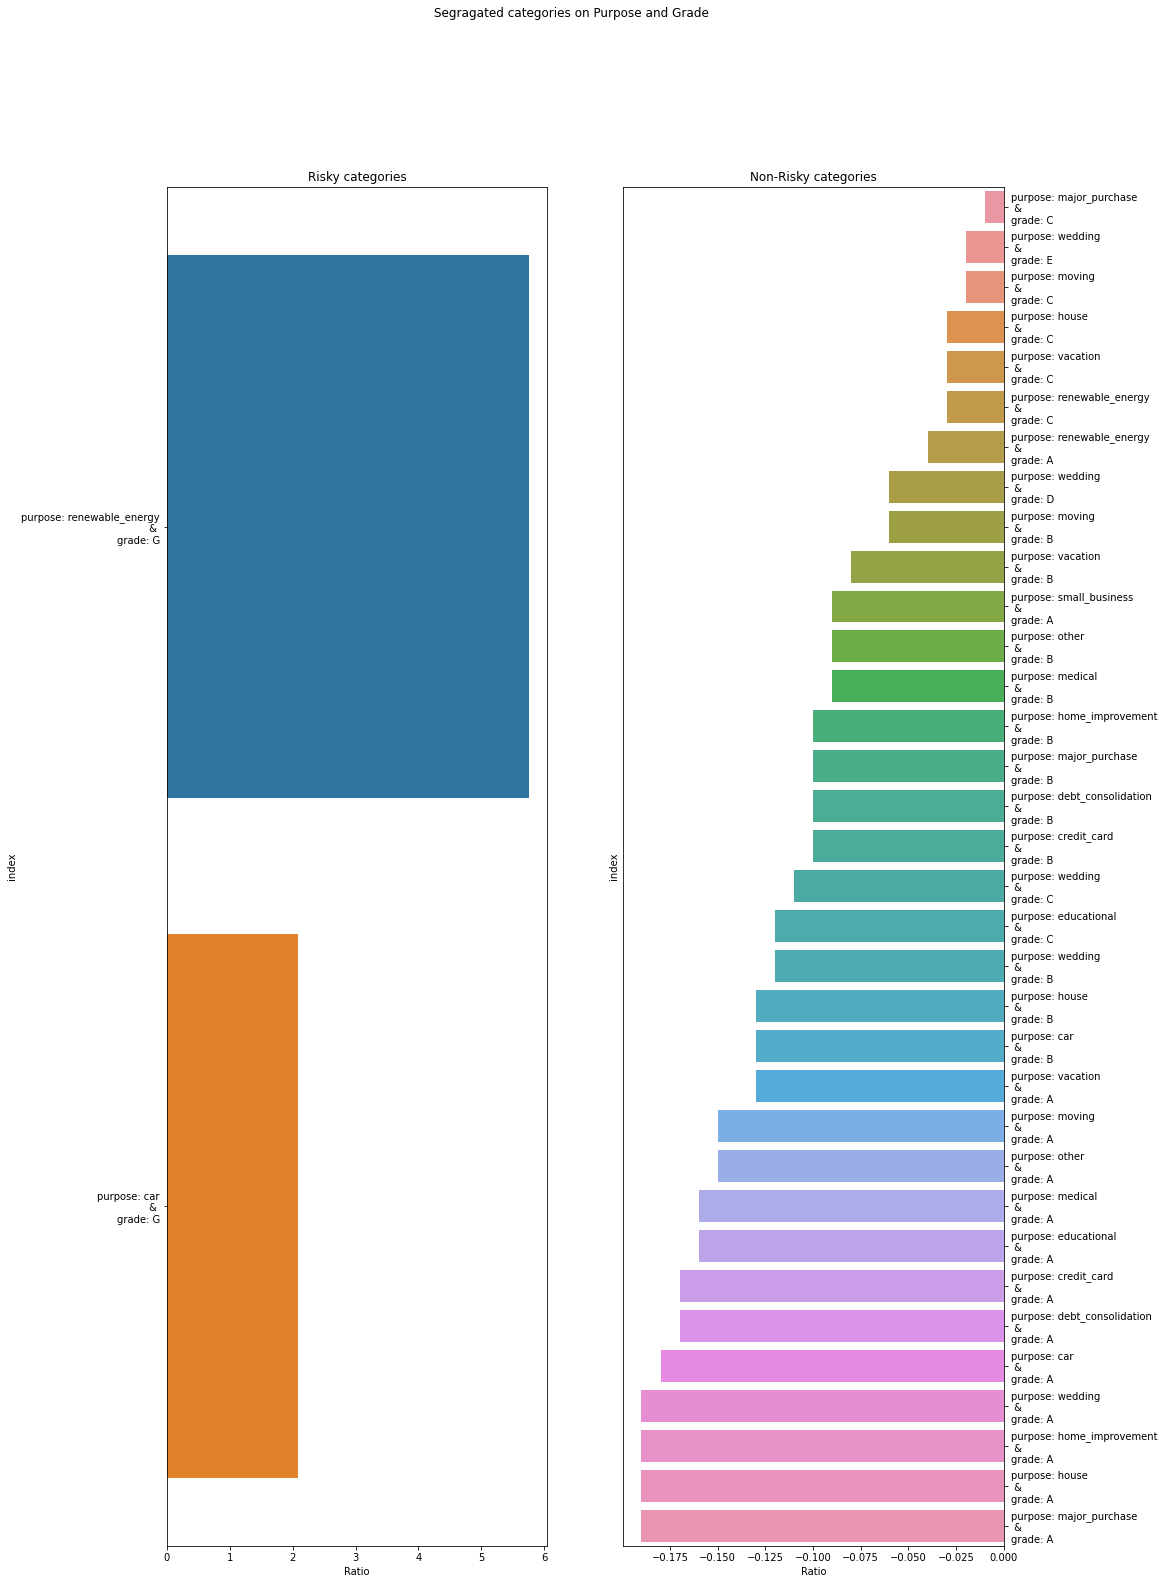

In [401]:
feat1 = 'purpose'
feat2 = 'grade'
tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

tmp['index'] = feat1 +': ' + tmp[feat1] + '\n & \n' + feat2 + ': ' + tmp[feat2]

fig, axes = plt.subplots(1,2,figsize=(15,25))
fig.suptitle('Segragated categories on Purpose and Grade')
tmpk = tmp[tmp['Ratio'] >2]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


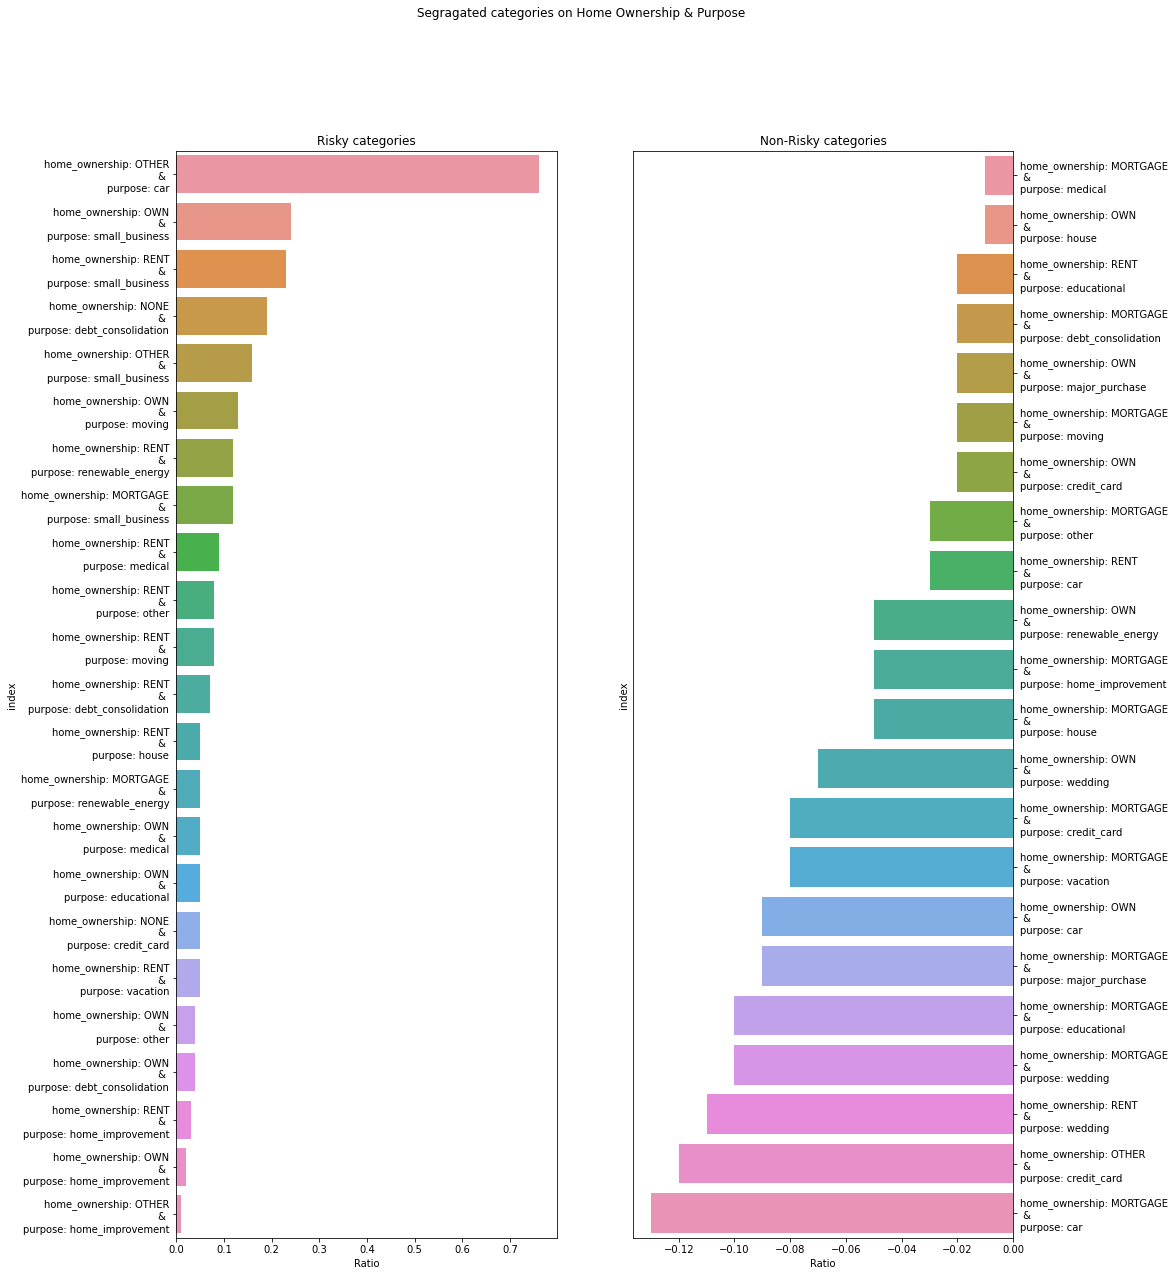

In [402]:
feat1 = 'home_ownership'
feat2 = 'purpose'

tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

tmp['index'] = feat1 +': ' + tmp[feat1] + '\n & \n' + feat2 + ': ' + tmp[feat2]

fig, axes = plt.subplots(1,2,figsize=(15,20))
fig.suptitle('Segragated categories on Home Ownership & Purpose')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


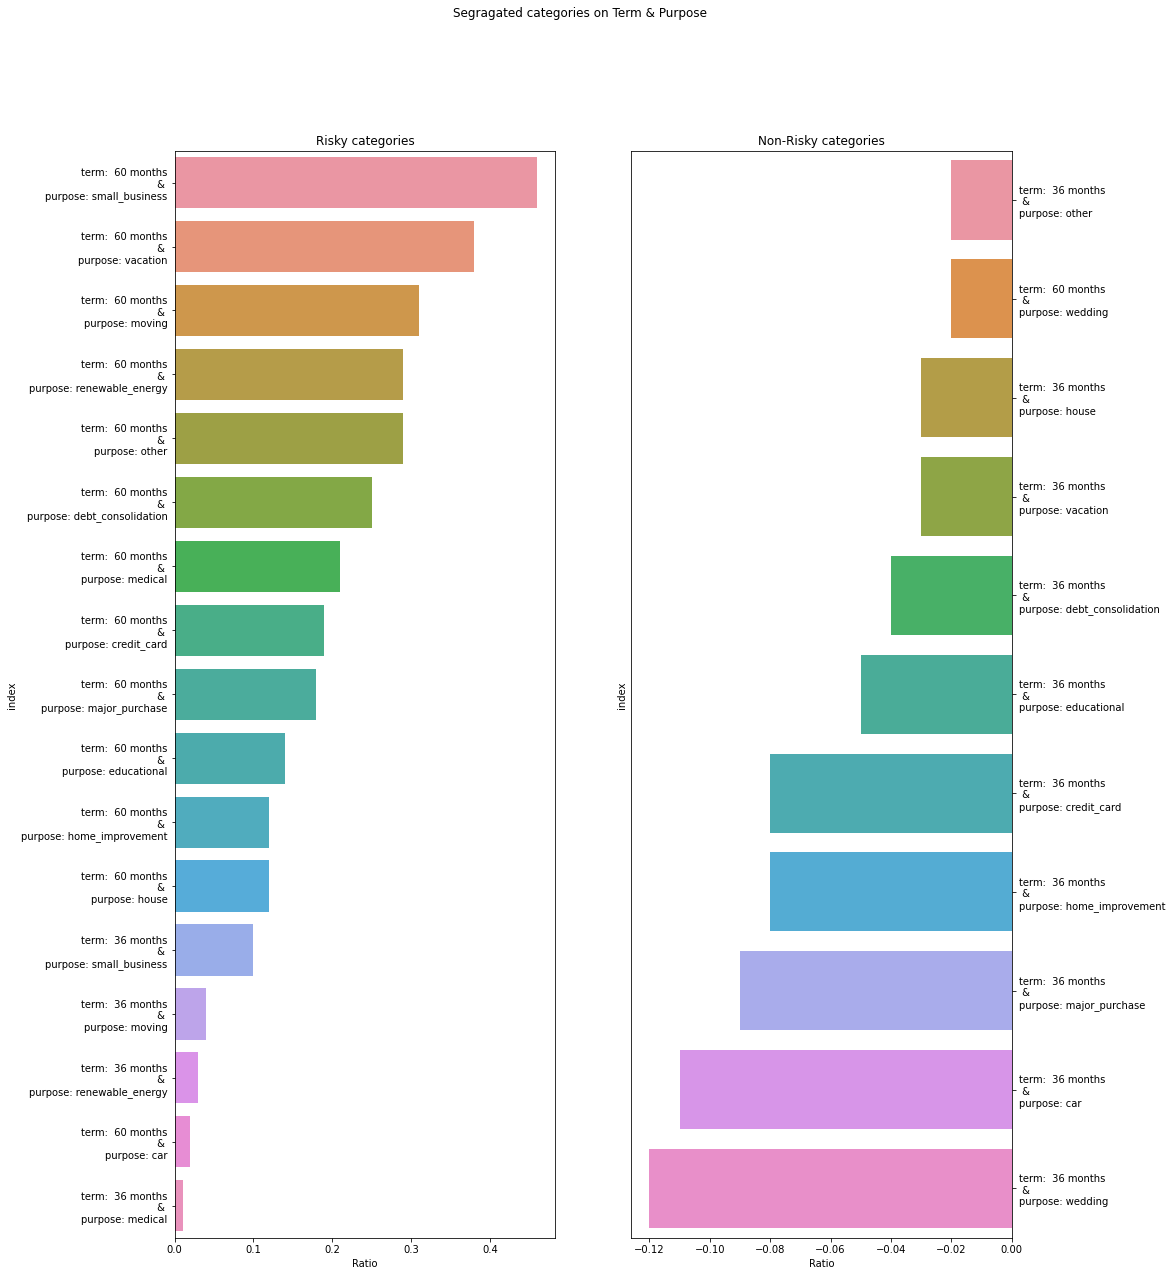

In [403]:
feat1 = 'term'
feat2 = 'purpose'

tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

tmp['index'] = feat1 +': ' + tmp[feat1] + '\n & \n' + feat2 + ': ' + tmp[feat2]

fig, axes = plt.subplots(1,2,figsize=(15,20))
fig.suptitle('Segragated categories on Term & Purpose')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


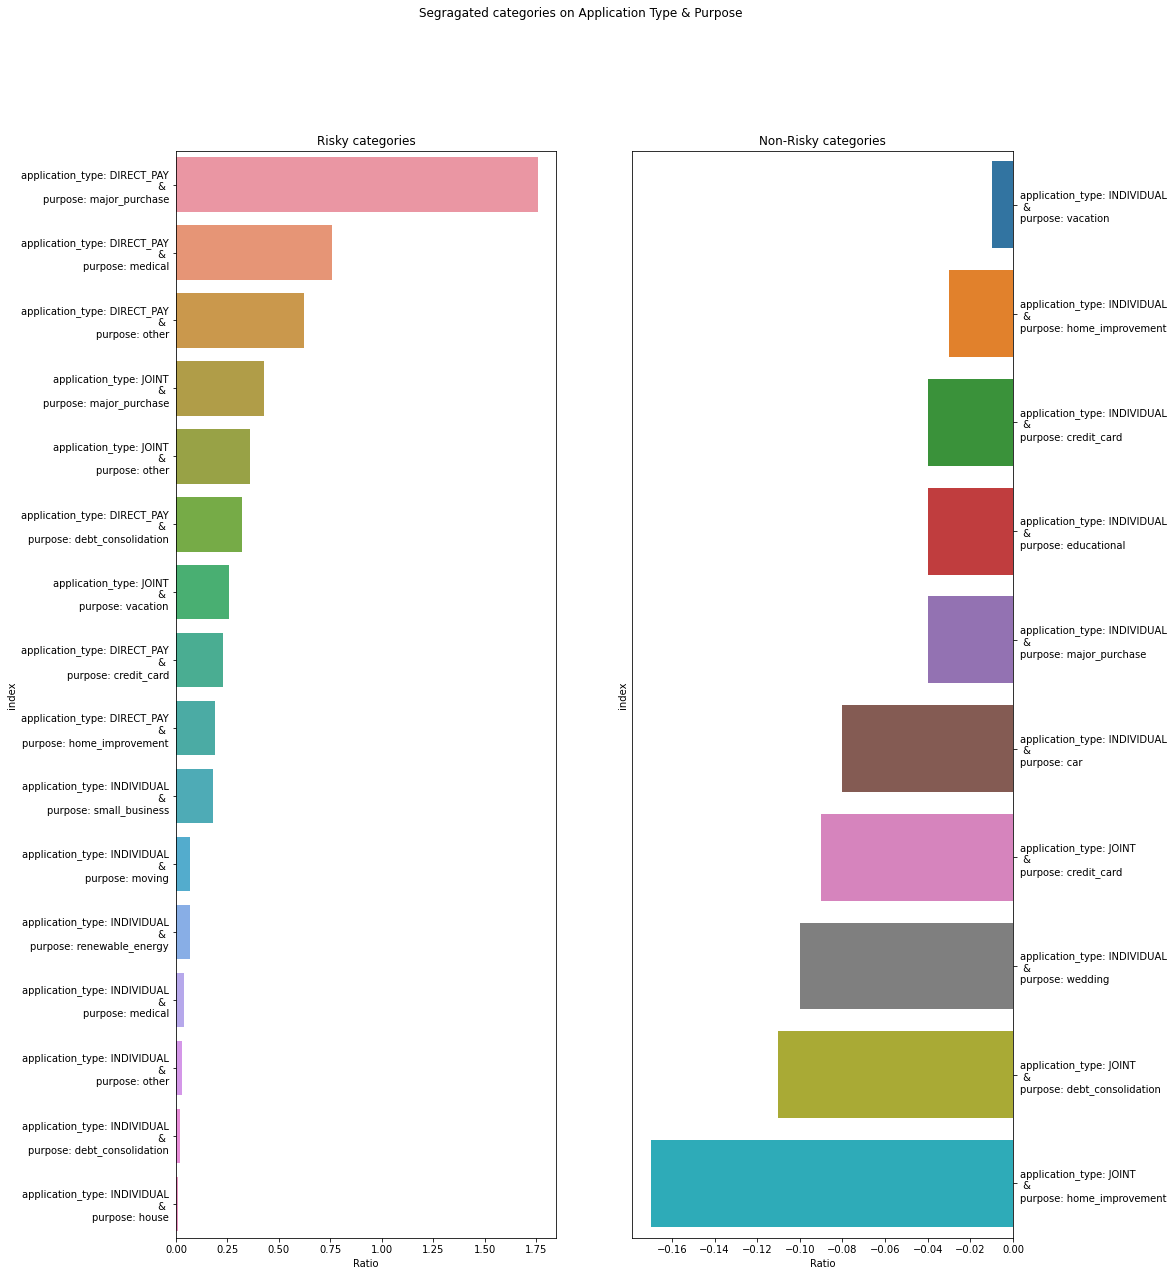

In [404]:
feat1 = 'application_type'
feat2 = 'purpose'

tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

tmp['index'] = feat1 +': ' + tmp[feat1] + '\n & \n' + feat2 + ': ' + tmp[feat2]

fig, axes = plt.subplots(1,2,figsize=(15,20))
fig.suptitle('Segragated categories on Application Type & Purpose')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


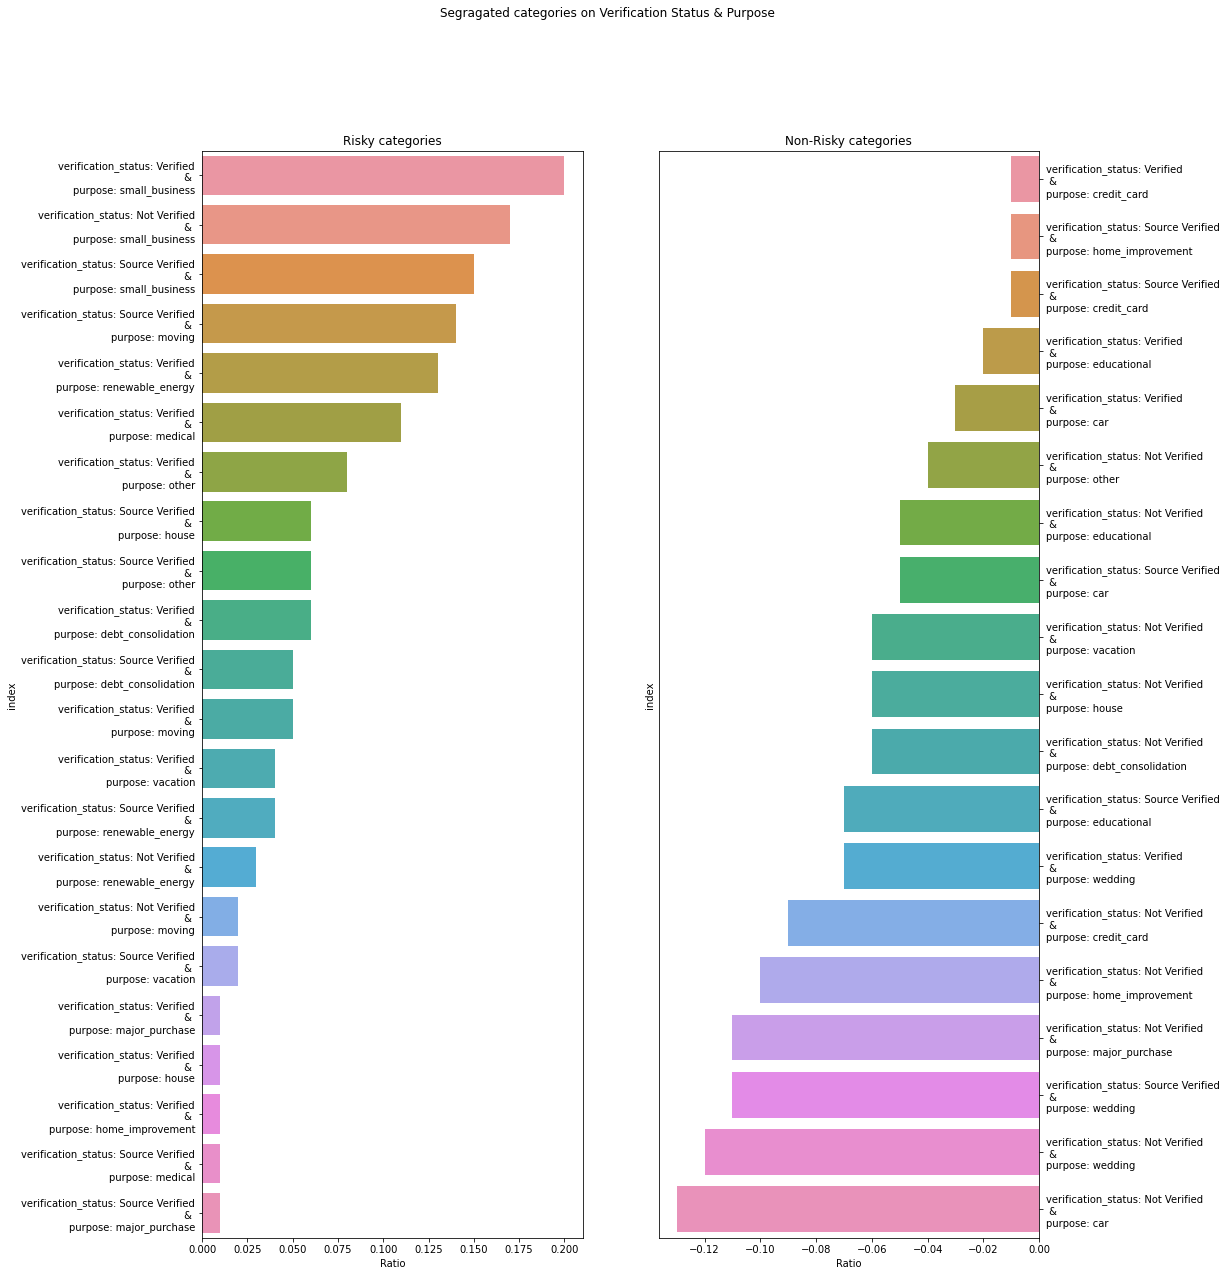

In [405]:
feat1 = 'verification_status'
feat2 = 'purpose'

tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

tmp['index'] = feat1 +': ' + tmp[feat1] + '\n & \n' + feat2 + ': ' + tmp[feat2]

fig, axes = plt.subplots(1,2,figsize=(15,20))
fig.suptitle('Segragated categories on Verification Status & Purpose')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


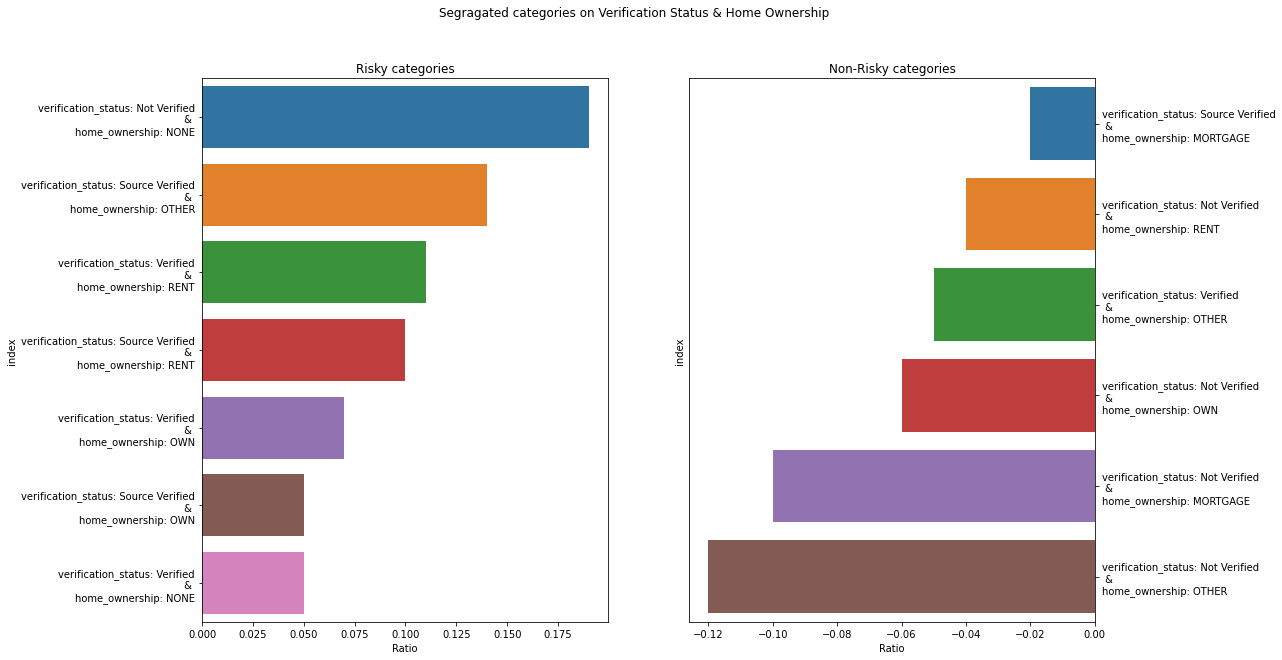

In [406]:
feat1 = 'verification_status'
feat2 = 'home_ownership'

tmp = data.copy()
tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

tmp['index'] = feat1 +': ' + tmp[feat1] + '\n & \n' + feat2 + ': ' + tmp[feat2]

fig, axes = plt.subplots(1,2,figsize=(16,10))
fig.suptitle('Segragated categories on Verification Status & Home Ownership')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


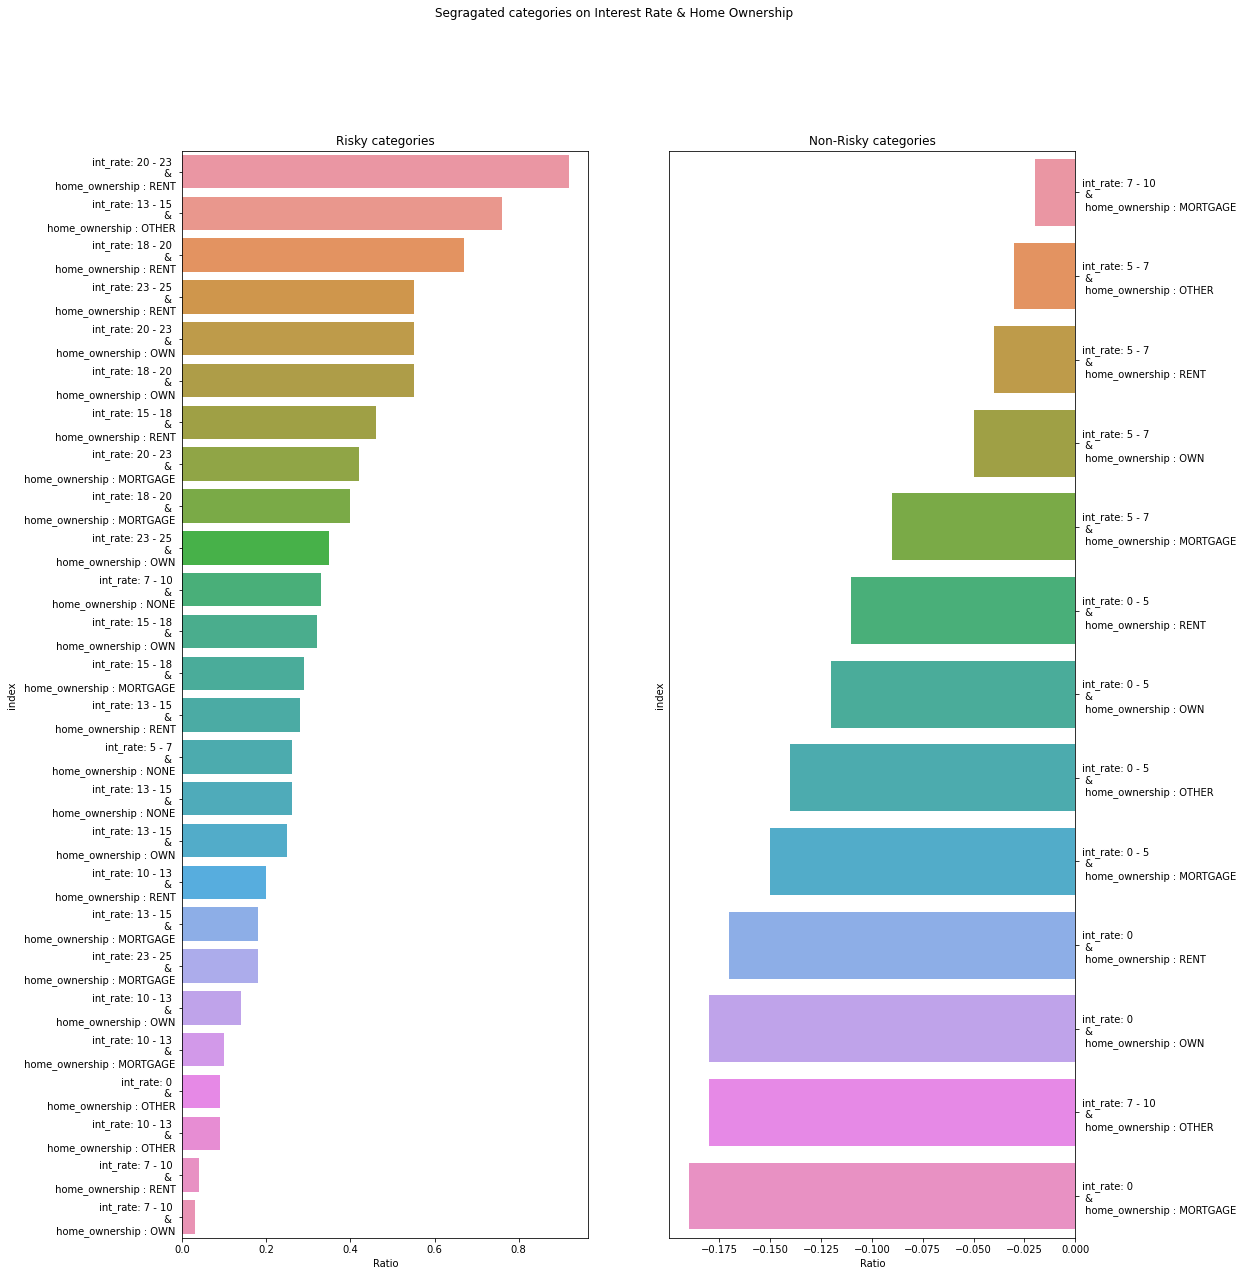

In [407]:
feat1 = 'int_rate'
feat2 = 'home_ownership'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp['int_rate']

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp['int_rate'] = Xt
tmp['int_rate'] = tmp['int_rate'].astype(int).astype(str).replace(dictm)

#print(tmp['int_rate'].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) + ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Interest Rate & Home Ownership')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


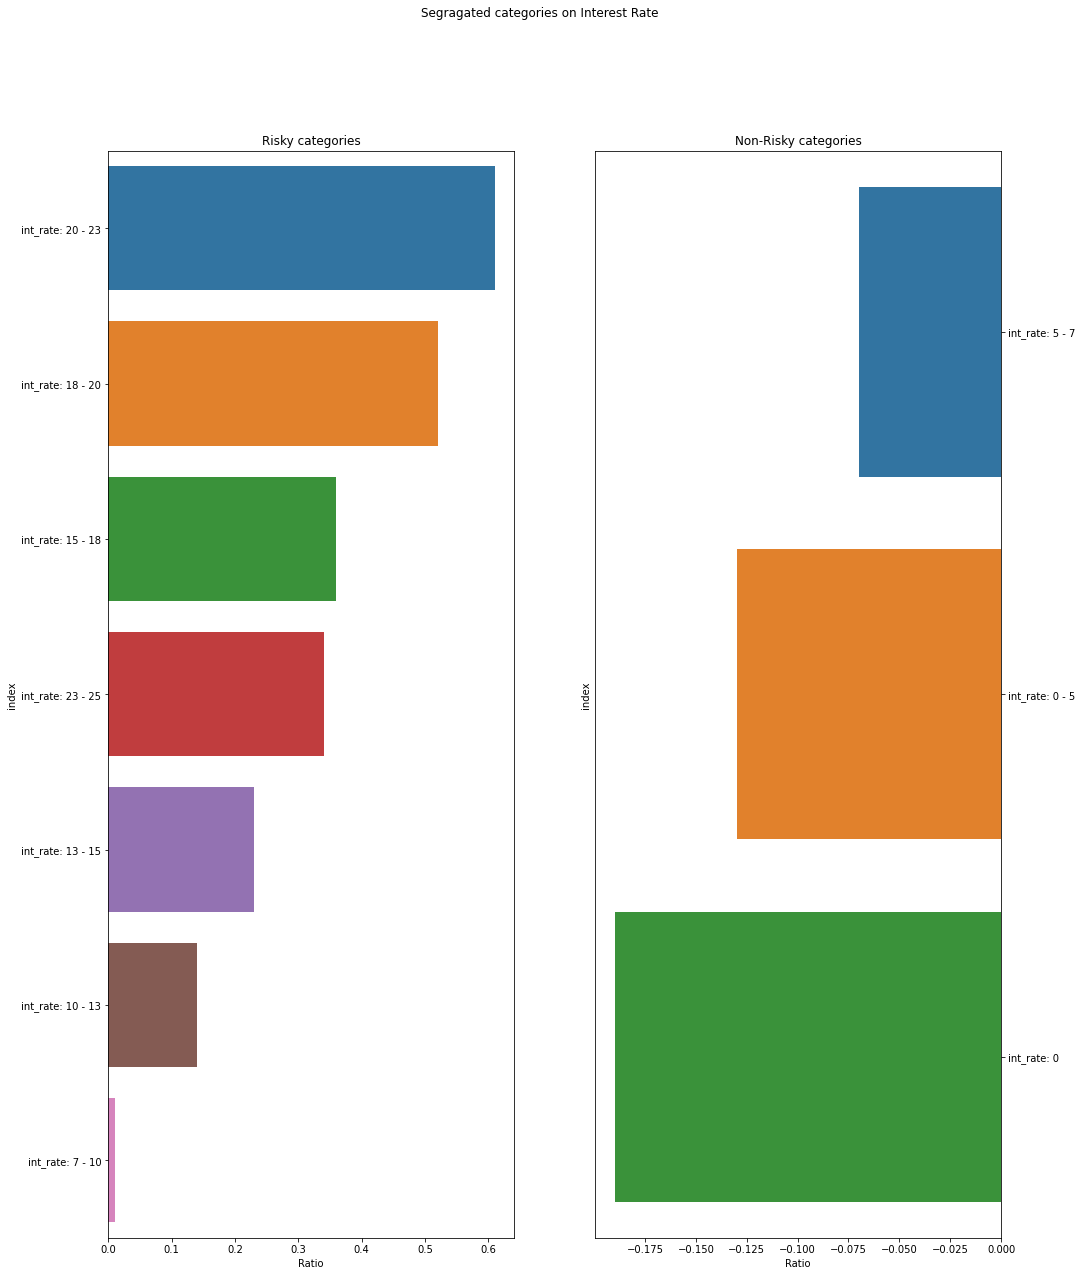

In [408]:
feat1 = 'int_rate'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp['int_rate']

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp['int_rate'] = Xt
tmp['int_rate'] = tmp['int_rate'].astype(int).astype(str).replace(dictm)

#print(tmp['int_rate'].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Interest Rate')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


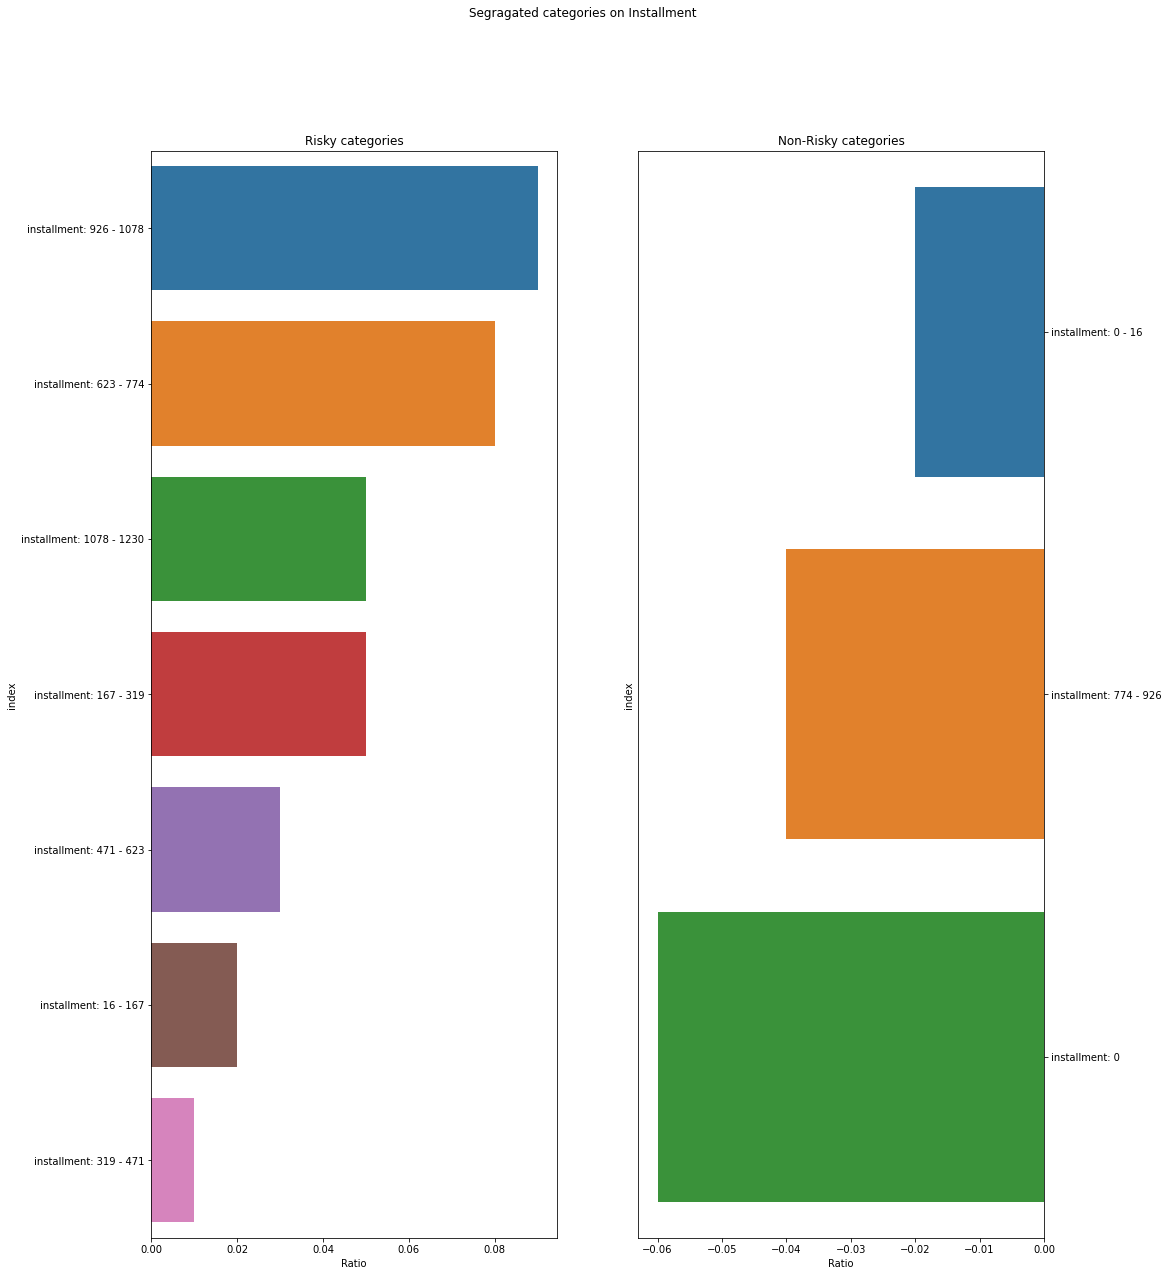

In [409]:
feat1 = 'installment'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)


tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Installment')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


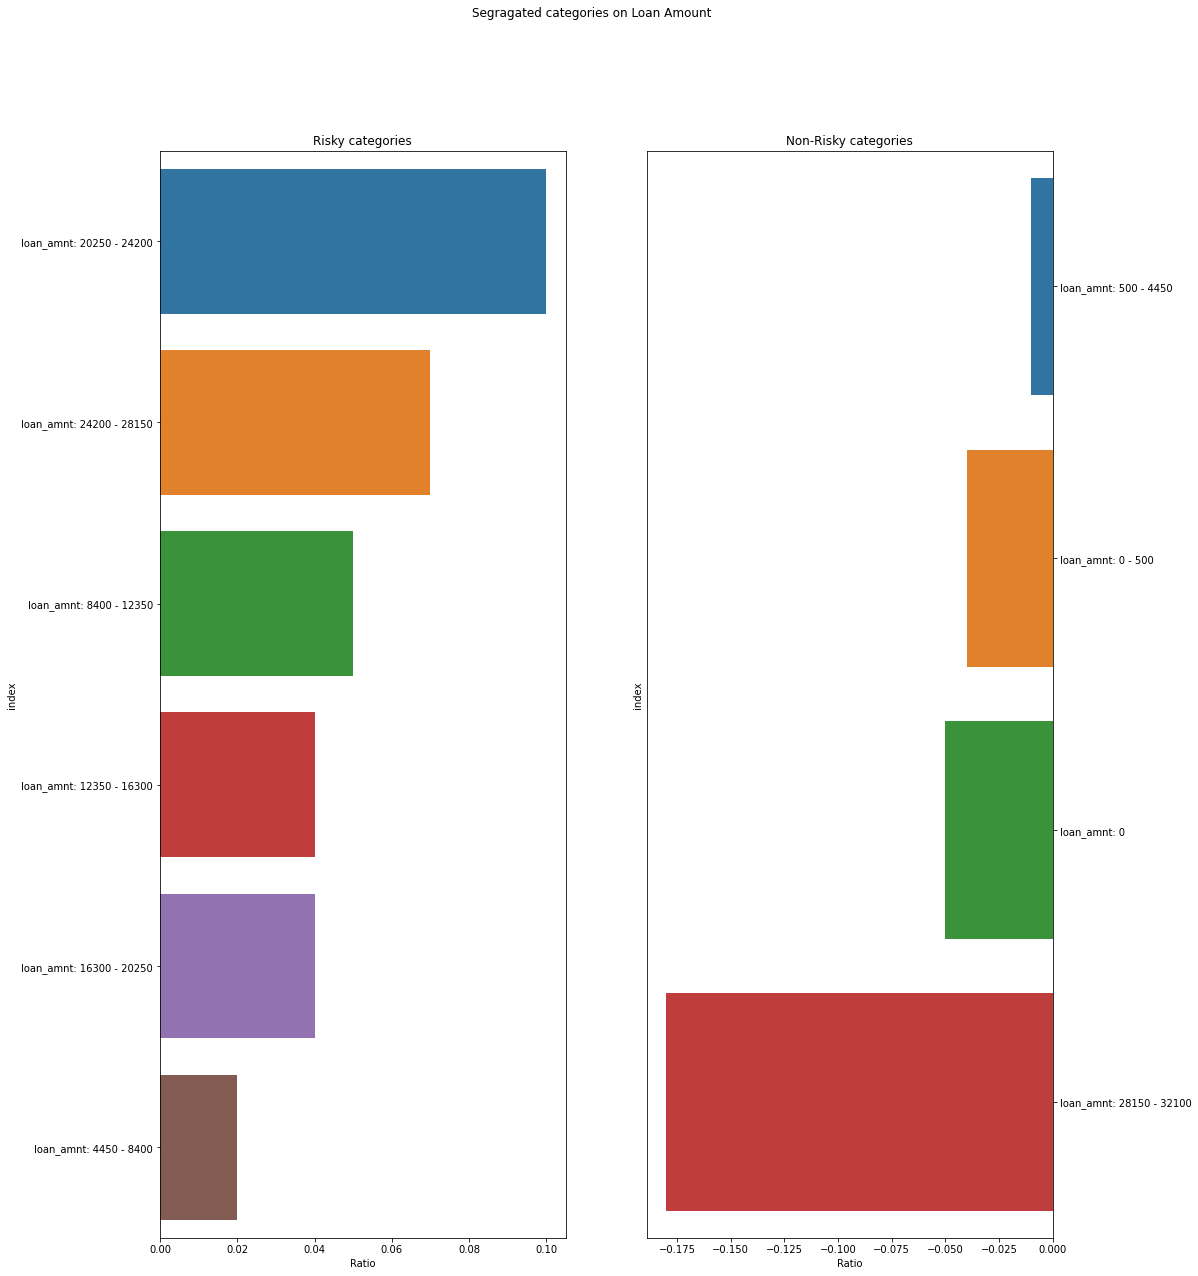

In [410]:
feat1 = 'loan_amnt'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)


tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Loan Amount')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

(396030, 27)
(30016, 27)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


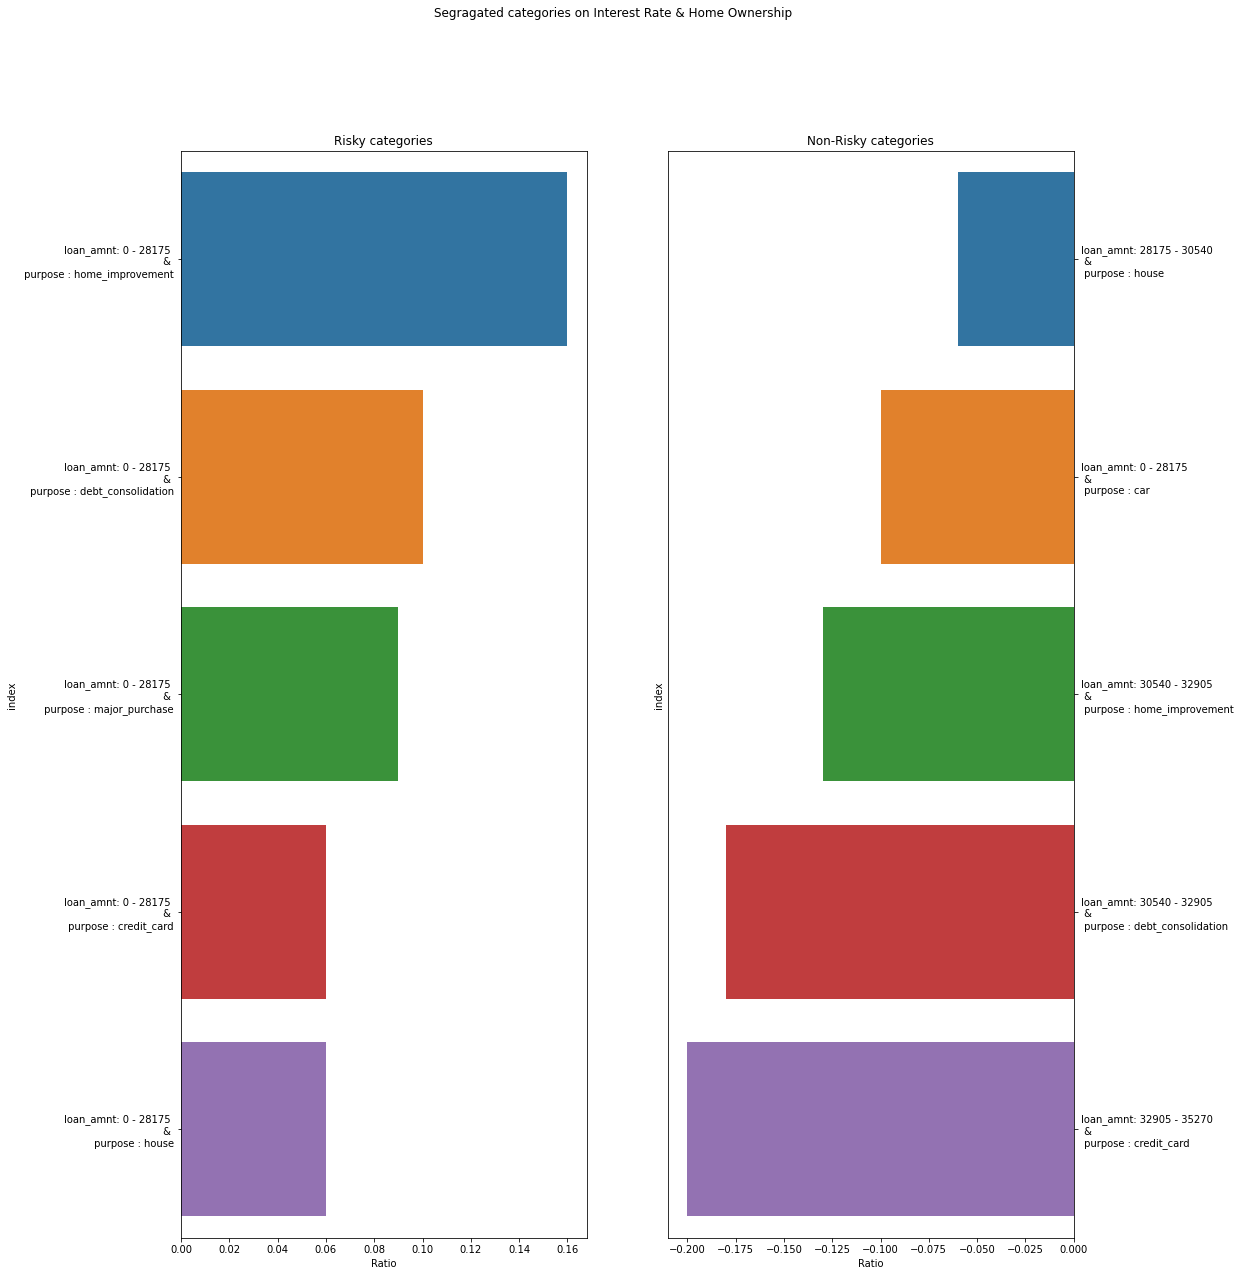

In [411]:
feat1 = 'loan_amnt'
feat2 = 'purpose'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy="uniform")


tmp = data.copy()
print(tmp.shape)
tmp = tmp[tmp[feat1]>28150]
print(tmp.shape)
target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)
tmp = tmp[tmp[feat1] != '0']
#print(tmp['int_rate'].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) + ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Interest Rate & Home Ownership')
tmpk = tmp[tmp['Ratio'] >0].head()


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0].head()

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

In [412]:
#tmp.groupby(['loan_amnt']).max()['Ratio'],tmp.groupby(['loan_amnt']).min()['Ratio']

#tmp.drop(['level_0'],axis=1,inplace=True)
#tmp.reset_index(drop=True).loc[tmp.reset_index().groupby(['loan_amnt'])['Ratio'].idxmax()]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


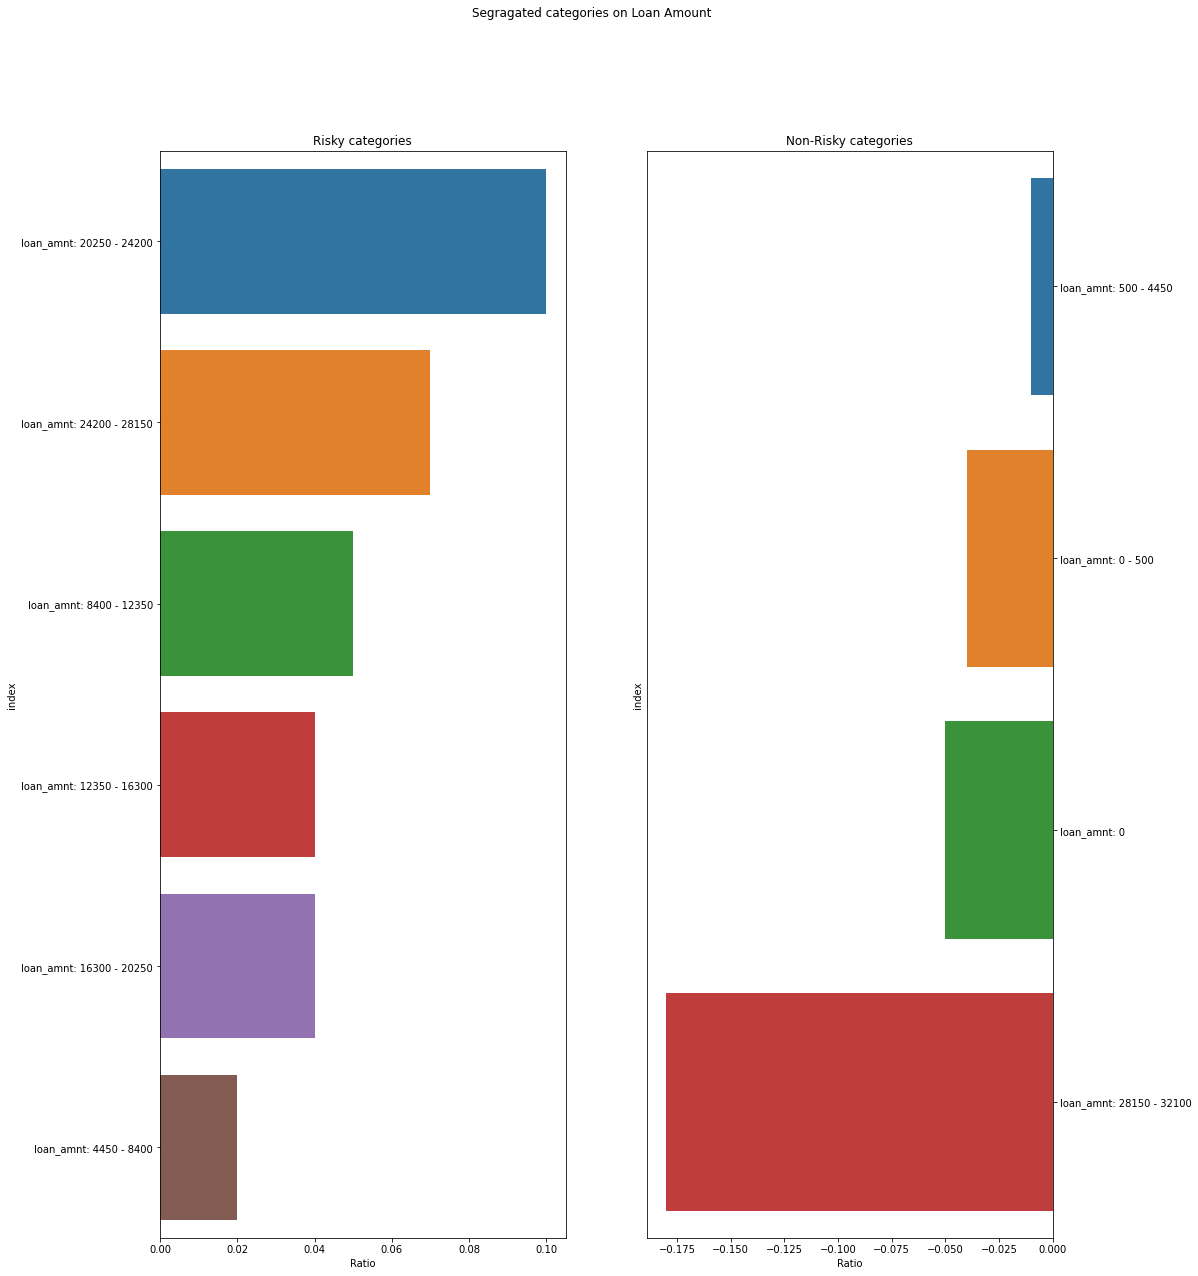

In [413]:
feat1 = 'loan_amnt'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)


tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Loan Amount')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


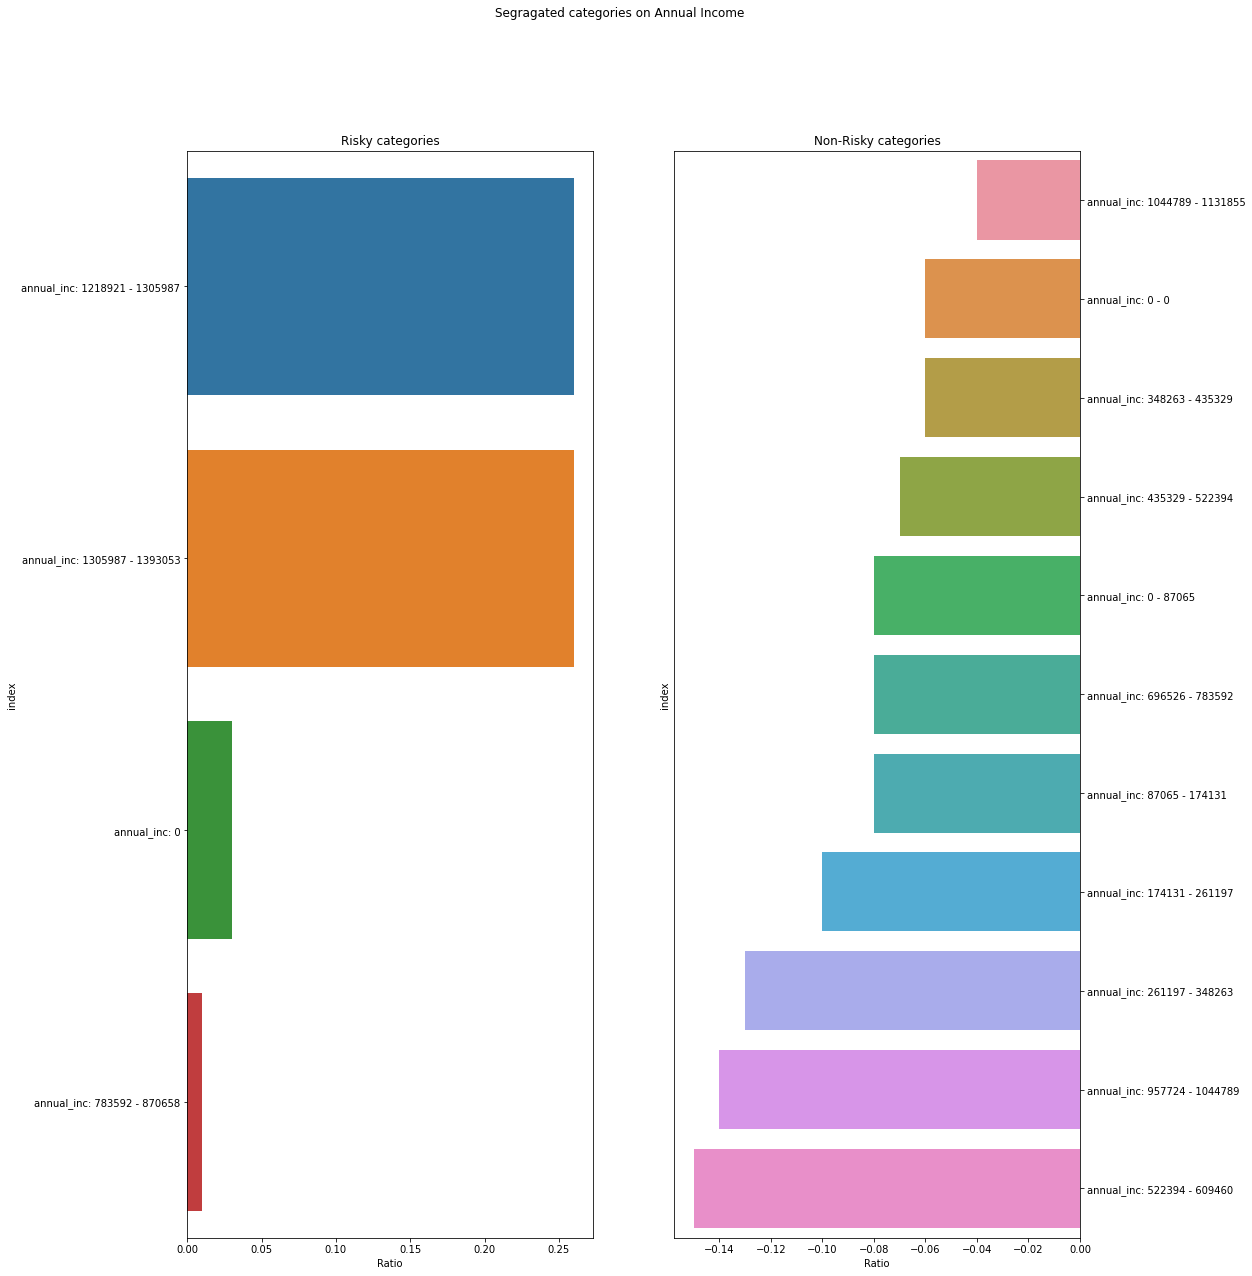

In [414]:
feat1 = 'annual_inc'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=100, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)

#print(tmp[feat1].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#print(tmp)
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Annual Income')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

(396030, 27)
(264849, 27)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


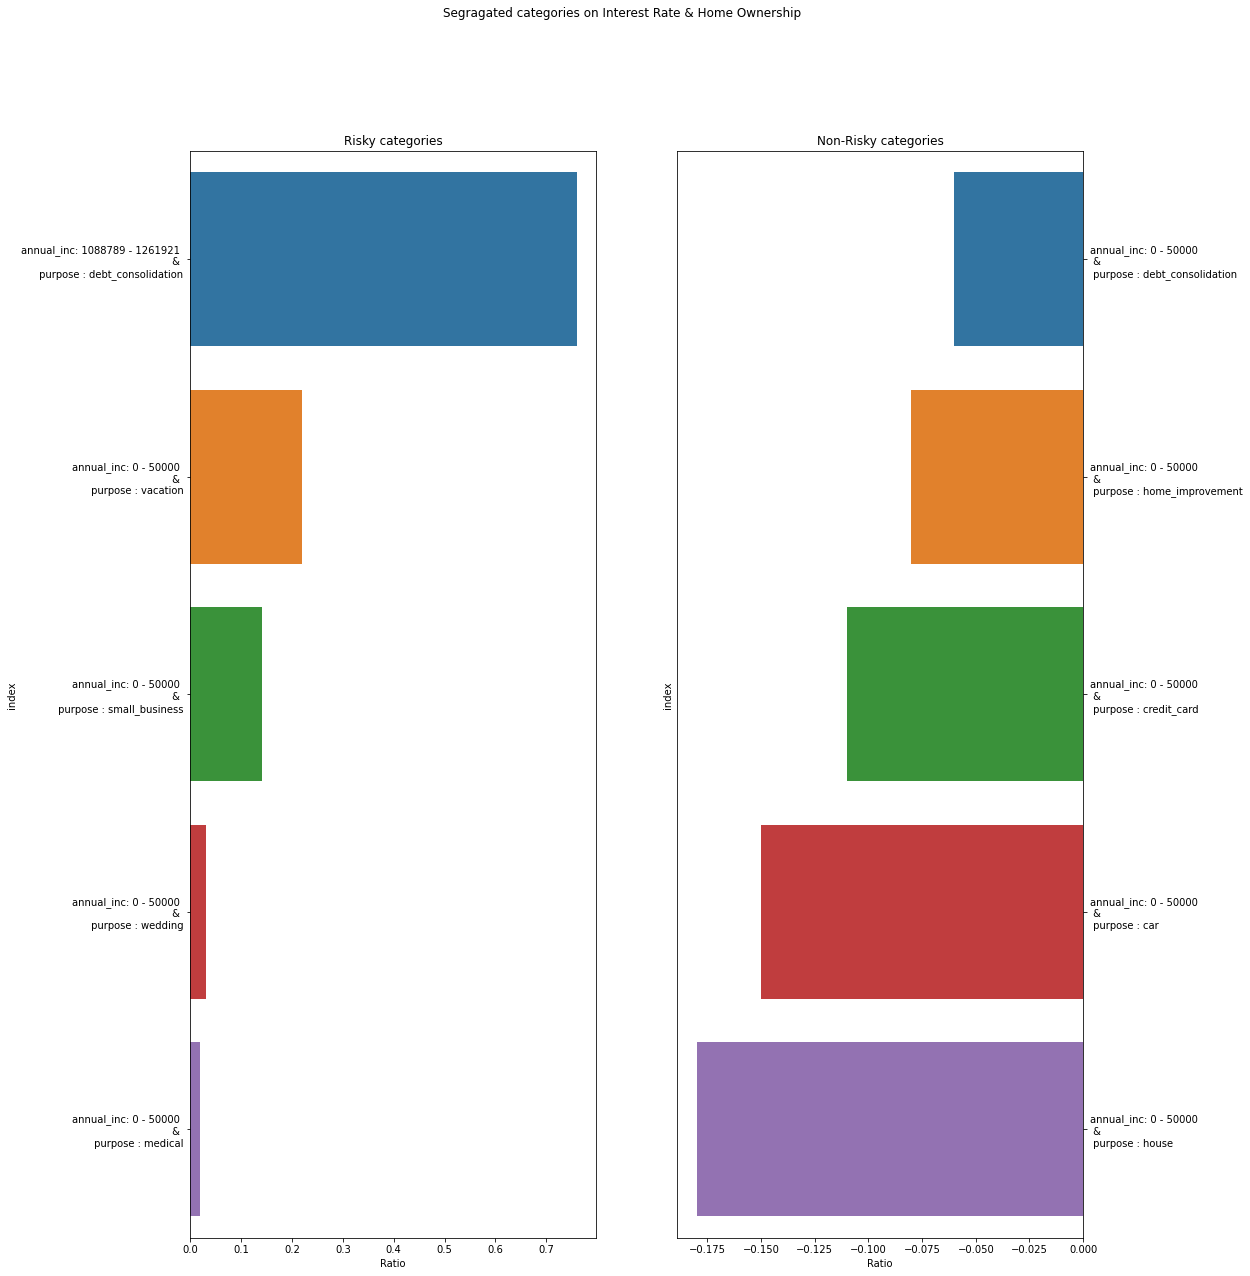

In [415]:
feat1 = 'annual_inc'
feat2 = 'purpose'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=50, encode='ordinal',strategy="uniform")


tmp = data.copy()
print(tmp.shape)
tmp = tmp[tmp[feat1]>50000]
print(tmp.shape)
target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)
tmp = tmp[tmp[feat1] != '0']
#print(tmp['int_rate'].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) + ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Interest Rate & Home Ownership')
tmpk = tmp[tmp['Ratio'] >0].head()


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0].head()

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


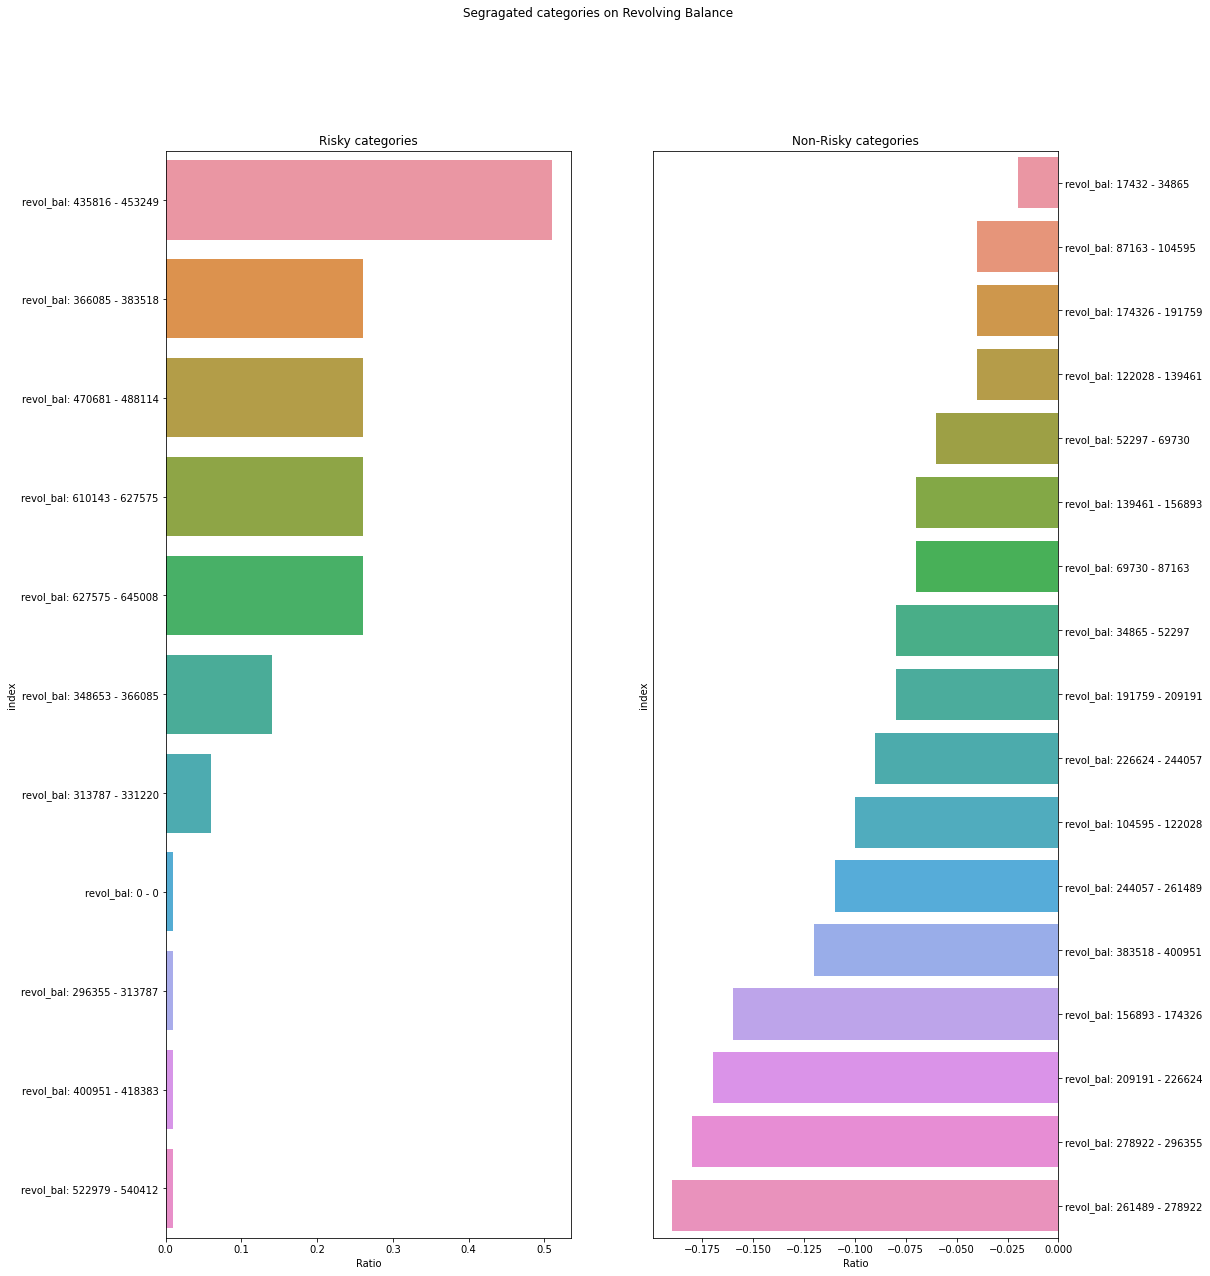

In [416]:
feat1 = 'revol_bal'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=100, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)

#print(tmp[feat1].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#print(tmp)
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Revolving Balance')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


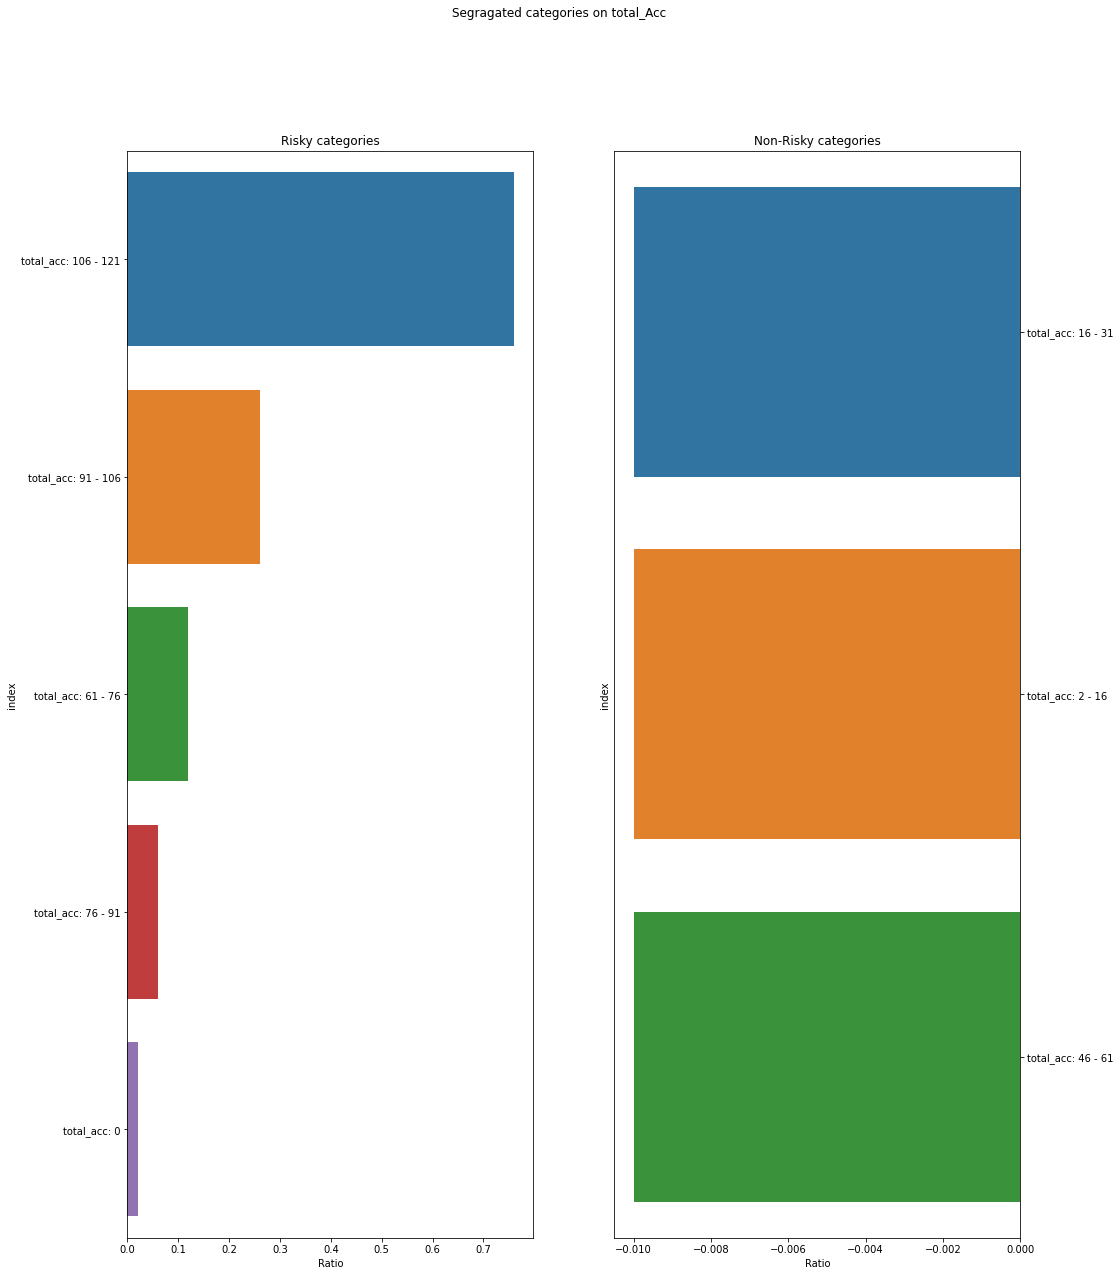

In [417]:
feat1 = 'total_acc'

from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")


tmp = data.copy()

target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)

#print(tmp[feat1].unique())

tmp['Count'] = 1
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) 
#print(tmp)
#+ ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on total_Acc')
tmpk = tmp[tmp['Ratio'] >0]


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0]

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

### **Analyzing effect of seasonality(quarterly)**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  if __name__ == '__main__':


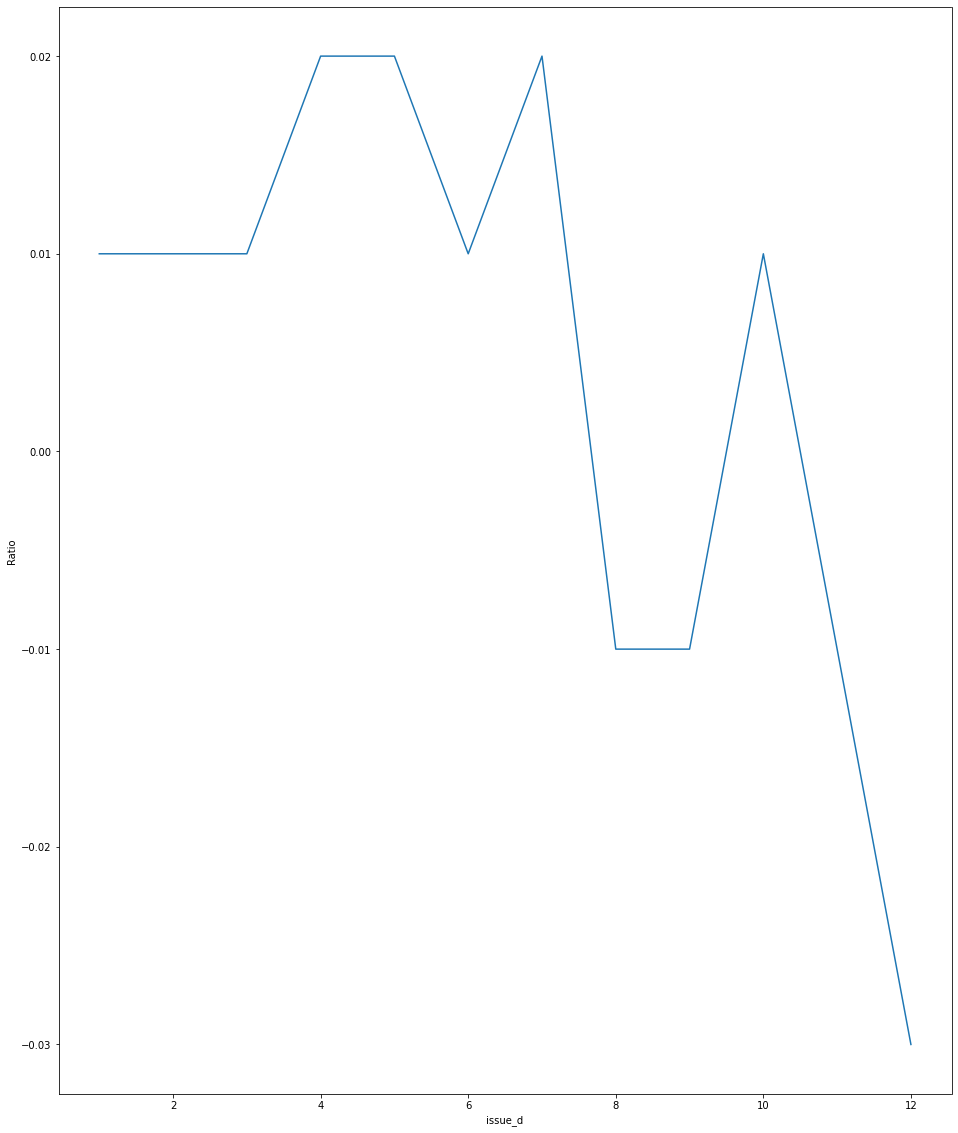

In [418]:

tmp = data.copy()
tmp['Count'] = 1

feat1 = 'issue_d'

tmp[feat1] = tmp[feat1].dt.month
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
plt.figure(figsize=(16,20))
#sns.lineplot(data=tmp,x=feat1,y='Charged Off')
#sns.lineplot(data=tmp,x=feat1,y='Fully Paid')
sns.lineplot(data=tmp,x=feat1,y='Ratio')
plt.show()
#tmp

First two quarters seems to be having higher Default Ratio than last two.


Lets check what type of loans are taken and defaulted most in first quarter.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


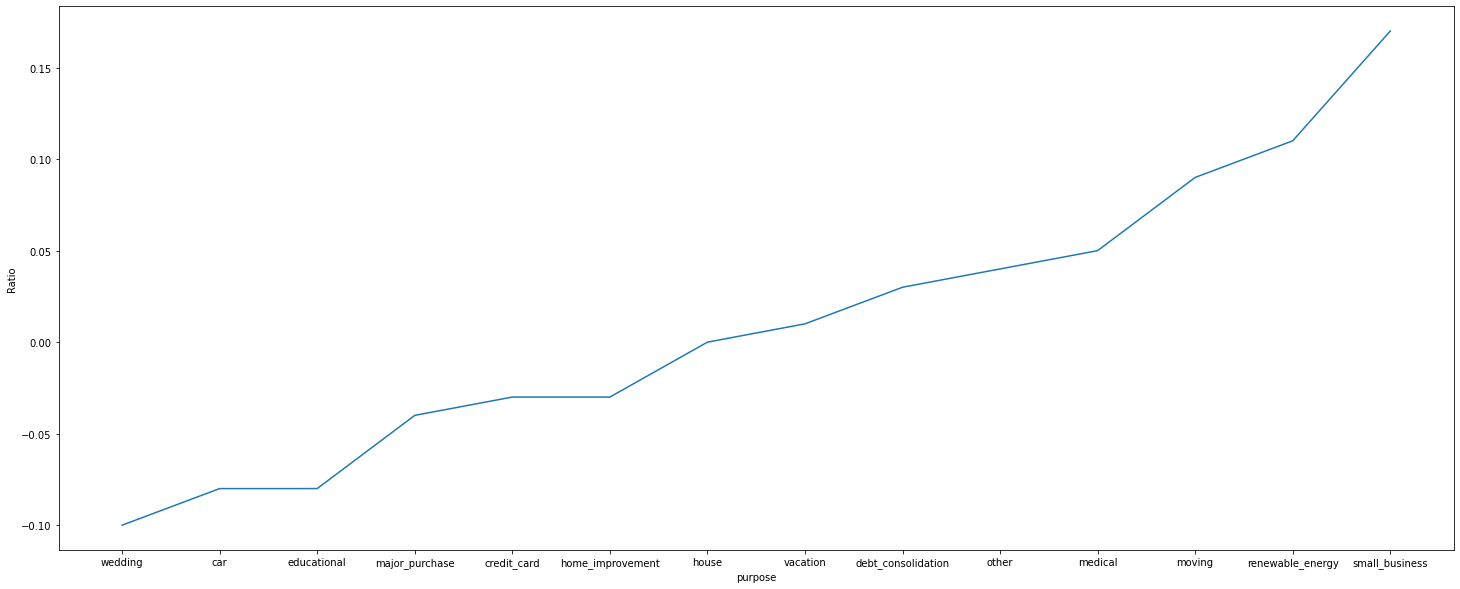

In [419]:

tmp = data.copy()
tmp['Count'] = 1

feat1 = 'issue_d'

tmp[feat1] = tmp[feat1].dt.quarter
tmp = tmp[tmp[feat1].isin([1,2])]
feat1 = 'purpose'
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp.sort_values('Ratio',inplace=True)
plt.figure(figsize=(25,10))
#sns.lineplot(data=tmp,x=feat1,y='Charged Off')
#sns.lineplot(data=tmp,x=feat1,y='Fully Paid')
sns.lineplot(data=tmp,x=feat1,y='Ratio')
plt.show()

Lets check the same relation from data of last 2 quarters

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


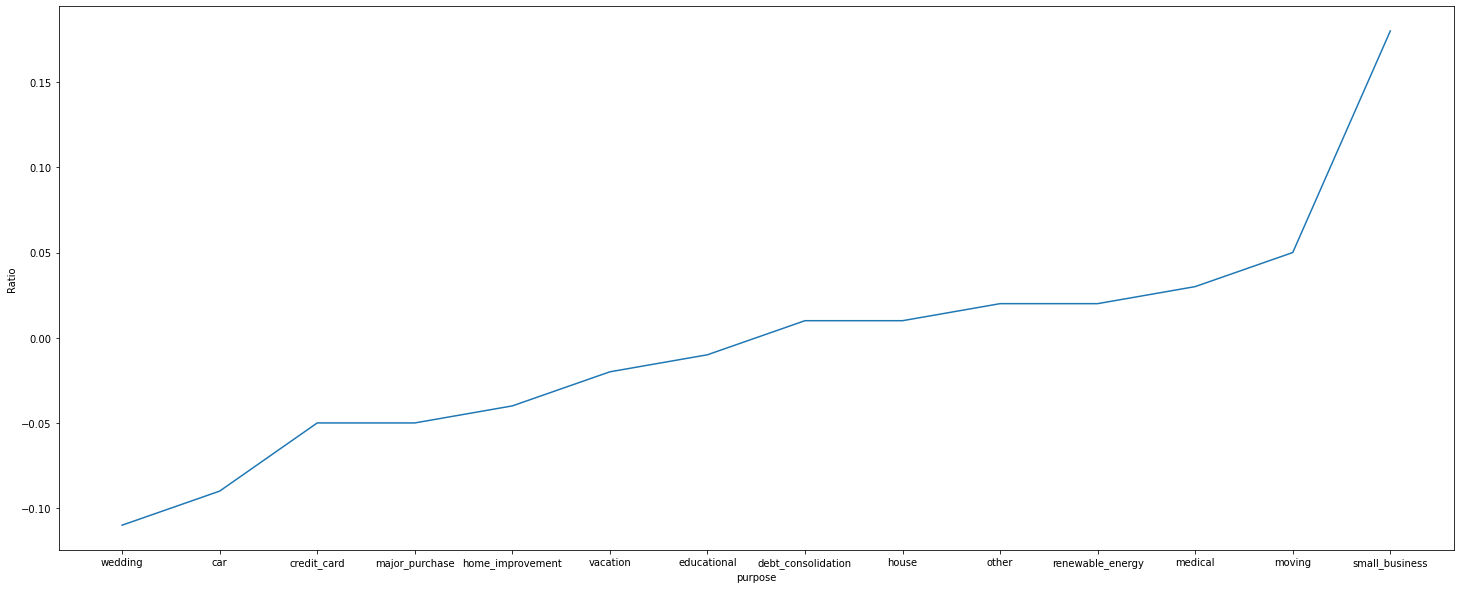

In [420]:

tmp = data.copy()
tmp['Count'] = 1

feat1 = 'issue_d'

tmp[feat1] = tmp[feat1].dt.quarter
tmp = tmp[tmp[feat1].isin([3,4])]
feat1 = 'purpose'
tmp = tmp.groupby([feat1,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1]).T.reset_index().dropna(0)
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio
tmp.sort_values('Ratio',inplace=True)
plt.figure(figsize=(25,10))
#sns.lineplot(data=tmp,x=feat1,y='Charged Off')
#sns.lineplot(data=tmp,x=feat1,y='Fully Paid')
sns.lineplot(data=tmp,x=feat1,y='Ratio')
plt.show()

Educational is getting lower in first two quarters (addmisions season in colleges might be playing role)

Renewable energy is getting higher in first two quarters (season might be playing role)


Let's check What of interest rates and purpose of loaans are being affected by deafulting in first two quarters.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


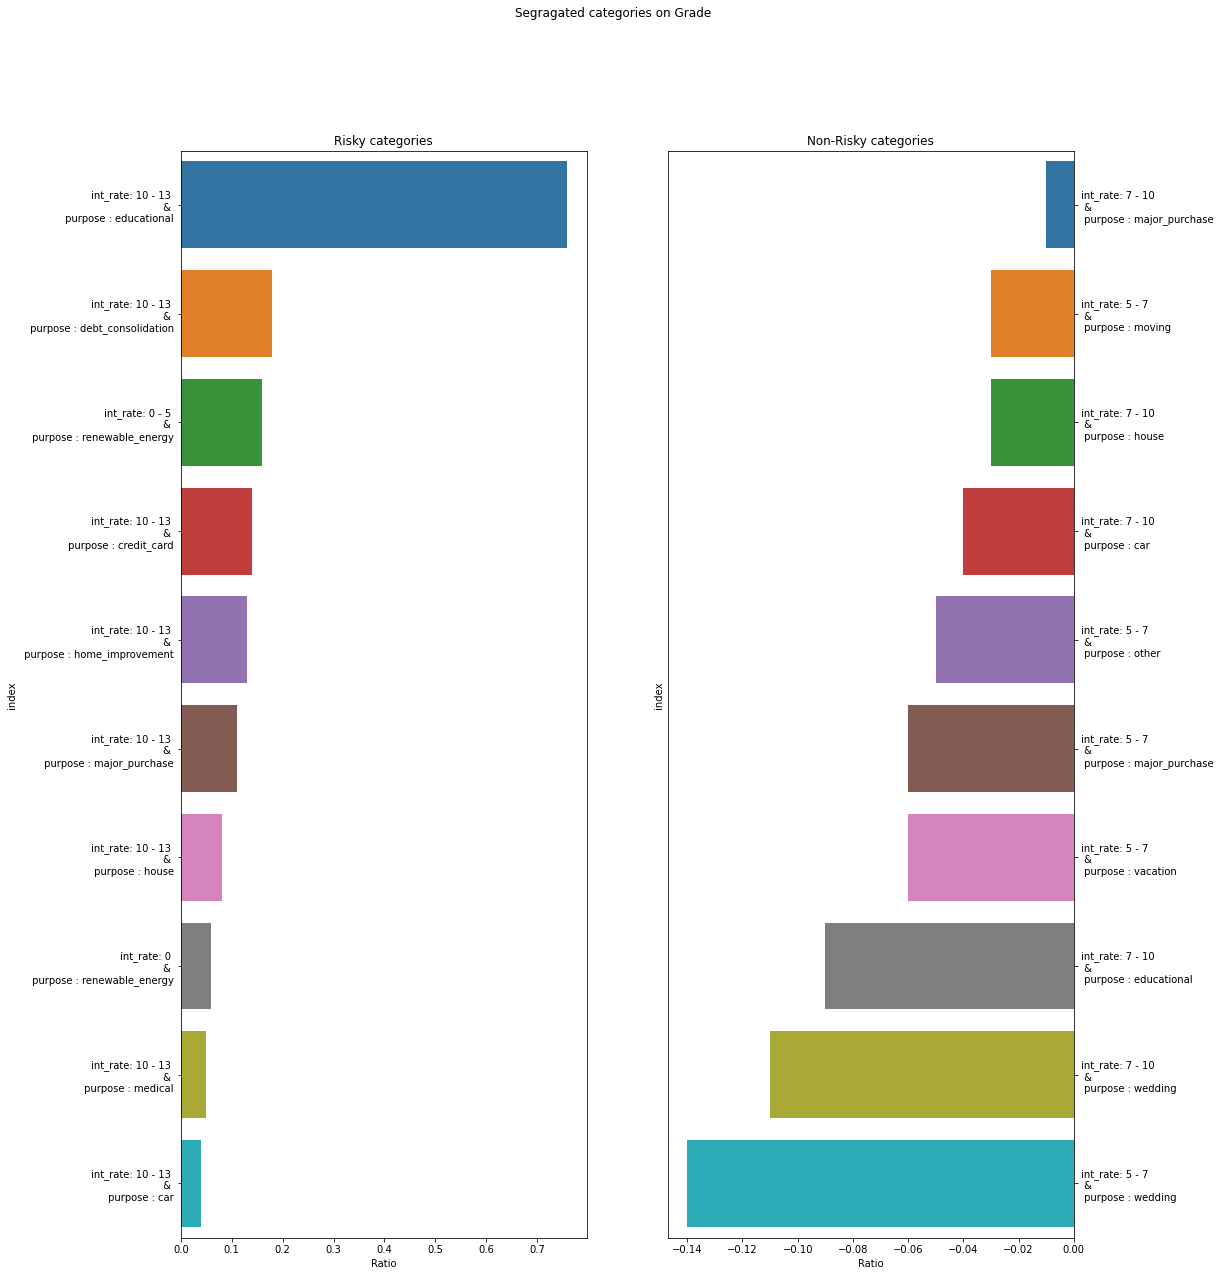

In [421]:

tmp = data.copy()
tmp['Count'] = 1

feat1 = 'issue_d'

tmp[feat1] = tmp[feat1].dt.quarter
tmp = tmp[tmp[feat1].isin([1,2])]





from sklearn.preprocessing import KBinsDiscretizer  
est = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy="uniform")




feat1 = 'int_rate'


feat2 = 'purpose'


target = tmp[feat1]

est.fit(target.values.reshape(-1, 1))

Xt = est.transform(target.values.reshape(-1, 1))
grps = [0] + list(est.bin_edges_[0])

dictm = {}
for i in range(1,len(grps)):
  dictm['{}'.format(i)] = str(int(grps[i-1])) + ' - ' + str(int(grps[i])) 

dictm

tmp[feat1] = Xt
tmp[feat1] = tmp[feat1].astype(int).astype(str).replace(dictm)

tmp = tmp.groupby([feat1,feat2,'loan_status']).sum()['Count'].reset_index()
#print(tmp.head())
tmp = pd.pivot(tmp,index=['loan_status'],values=['Count'],columns=[feat1,feat2]).T.reset_index().dropna(0)
#print(tmp.head())
tmp['Ratio'] = round(tmp['Charged Off']/(tmp['Fully Paid']),2) -ratio

#print(tmp)

tmp['index'] = feat1 +': ' + tmp[feat1].astype(str) + ' \n & \n ' + feat2 + ' : ' + tmp[feat2].astype(str)

fig, axes = plt.subplots(1,2,figsize=(16,20))
fig.suptitle('Segragated categories on Grade')
tmpk = tmp[tmp['Ratio'] >0].head(10)


tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[0].set_title('Risky categories')

sns.barplot(ax=axes[0],data=tmpk,y='index',x='Ratio')


tmpk = tmp[tmp['Ratio'] <0].tail(10)

tmpk.sort_values('Ratio',inplace=True,ascending=False)

axes[1].set_title('Non-Risky categories')
g2 = sns.barplot(ax=axes[1],data=tmpk,y='index',x='Ratio')
g2.yaxis.tick_right()


plt.show()

As evident from above plot, Education loans with high int rate (10-13%) have high defaulting ratio.

In [422]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,plot_roc_curve,fbeta_score
from sklearn.metrics import PrecisionRecallDisplay,precision_recall_curve, f1_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [423]:
df = pd.concat([X,y],axis=1)

In [424]:
for i in ['pub_rec','total_acc','mort_acc', 'pub_rec_bankruptcies']:
    X[i+'_flag'] = X[i]>1

In [425]:
#y = dfh['loan_status']
#X = dfh.drop(['loan_status'],axis=1)
#X.head()

In [426]:
y = y.replace({'Charged Off': 1,'Fully Paid':0})

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42,stratify=y)

## Vanilla Model

In [428]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,
                                                         solver='saga'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=0, solver='saga'))])

### Model Performance Stats on Training data

In [429]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))
print('F1 Score on Training data : ',f1_score(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89    159178
           1       0.53      0.08      0.13     38837

    accuracy                           0.81    198015
   macro avg       0.67      0.53      0.51    198015
weighted avg       0.76      0.81      0.74    198015

F1 Score on Training data :  0.13443226733740568


## Model with balanced classes and regularization

In [430]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,
                                                         solver='saga',
                                                         class_weight='balanced',l1_ratio=1,))
clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', l1_ratio=1,
                                    random_state=0, solver='saga'))])

### Model Performance Stats on Training data

In [431]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))
print('F1 Score on Training data : ',f1_score(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76    159178
           1       0.32      0.64      0.42     38837

    accuracy                           0.66    198015
   macro avg       0.60      0.65      0.59    198015
weighted avg       0.77      0.66      0.69    198015

F1 Score on Training data :  0.4246206138845018


## Model with reweighted classes and regularization

In [432]:
for w in [1,3,5,7]:
    print('---Weight of {} for Default class---'.format(w))
    lr_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,
                                                         solver='liblinear',
                                                         l1_ratio=1,class_weight={0:1,1:w}))
    
    lr_model.fit(X_train,y_train)
    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]

    pred = lr_model.predict(X_train)
    print(f1_score(y_train,pred))

---Weight of 1 for Default class---


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


0.13443226733740568
---Weight of 3 for Default class---


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


0.41192020614892483
---Weight of 5 for Default class---


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


0.4183541132431397
---Weight of 7 for Default class---


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


0.3942229623615448


In [445]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,
                                                         solver='liblinear',
                                                         l1_ratio=1,class_weight={0:1,1:5}))

clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 1, 1: 5}, l1_ratio=1,
                                    random_state=0, solver='liblinear'))])

### Model Performance Stats on Training data with Reweighting classes

In [446]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))
print('F1 Score on Training data : ',f1_score(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.40      0.55    159376
           1       0.61      0.95      0.74    156324

    accuracy                           0.67    315700
   macro avg       0.75      0.68      0.65    315700
weighted avg       0.75      0.67      0.65    315700

F1 Score on Training data :  0.7427404616884363


### Model Performance Stats on Testing data with Reweighting classes

In [447]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('F1 Score on Testing data : ',f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.40      0.55    158981
           1       0.61      0.95      0.74    156720

    accuracy                           0.67    315701
   macro avg       0.75      0.68      0.65    315701
weighted avg       0.75      0.67      0.65    315701

F1 Score on Testing data :  0.743708358645965


## Model with Resampling methods(ADASYN)

In [435]:
from imblearn.over_sampling import ADASYN

In [436]:
ada = ADASYN(random_state=42)

X_res, y_res = ada.fit_resample(X, y)

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.50, random_state=42)

In [438]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,
                                                         solver='liblinear',
                                                         class_weight='balanced',l1_ratio=1,))
clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', l1_ratio=1,
                                    random_state=0, solver='liblinear'))])

### Model Performance Stats on Training data with resampling (ADASYN)

In [439]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))
print('F1 Score on Training data : ',f1_score(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85    159376
           1       0.93      0.71      0.81    156324

    accuracy                           0.83    315700
   macro avg       0.85      0.83      0.83    315700
weighted avg       0.85      0.83      0.83    315700

F1 Score on Training data :  0.8057720871233887


### Model Performance Stats on Training data with resampling (ADASYN)

In [440]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('F1 Score on Testing data : ',f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85    158981
           1       0.93      0.71      0.81    156720

    accuracy                           0.83    315701
   macro avg       0.85      0.83      0.83    315701
weighted avg       0.85      0.83      0.83    315701

F1 Score on Testing data :  0.8054606769941028


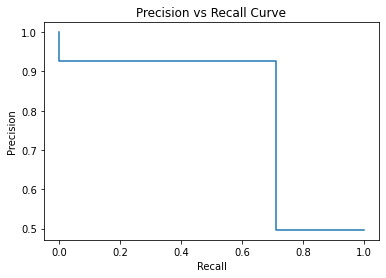

In [441]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision vs Recall Curve")
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


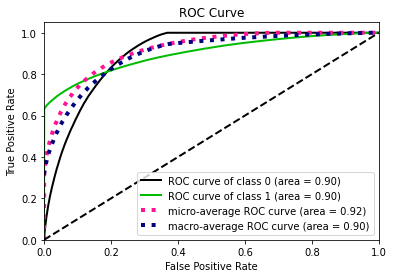

In [442]:
import scikitplot as skplt

y_probas = clf.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title("ROC Curve")
plt.show()

<AxesSubplot:xlabel='column', ylabel='weight'>

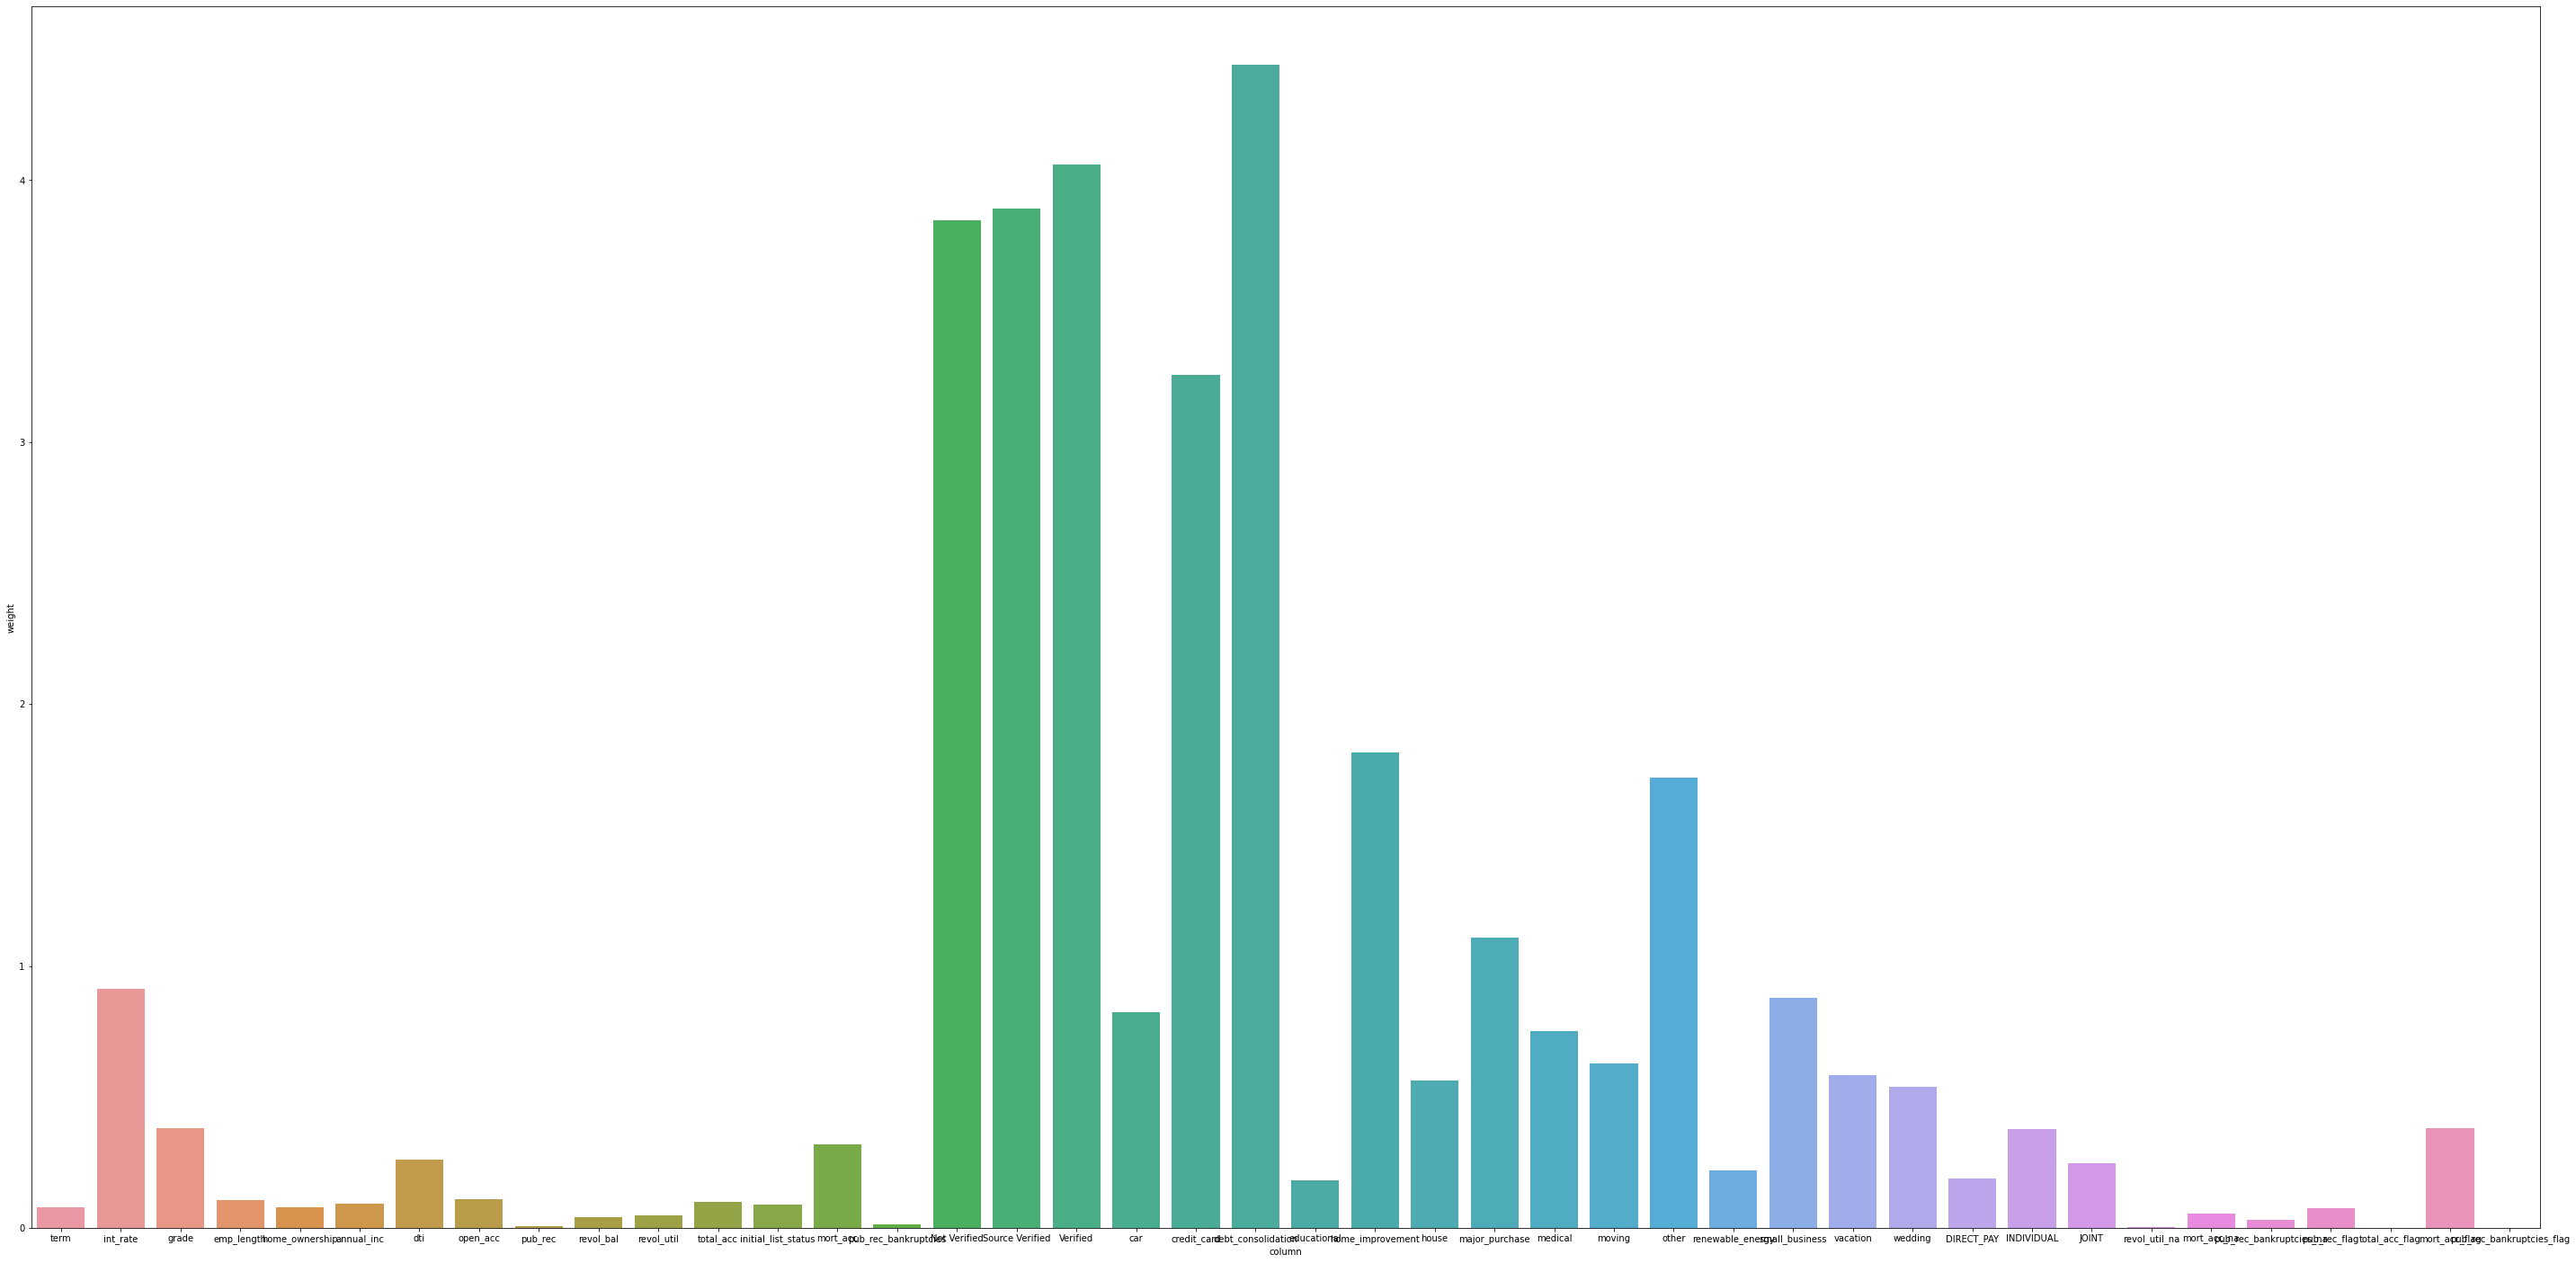

In [443]:
df = pd.DataFrame()
df['column'] = np.array(X.columns)
df['weight'] =np.abs(clf.named_steps['logisticregression'].coef_[0])
df['extra'] = clf.named_steps['logisticregression'].coef_[0]

df
plt.figure(figsize=(50,25))
sns.barplot(data=df,x='column',y='weight')

In [444]:
df.sort_values('weight',ascending=False).head(10)

,column,weight,extra
20,debt_consolidation,4.441872,-4.441872
17,Verified,4.059973,-4.059973
16,Source Verified,3.892791,-3.892791
15,Not Verified,3.846504,-3.846504
19,credit_card,3.257347,-3.257347
22,home_improvement,1.815023,-1.815023
27,other,1.718739,-1.718739
24,major_purchase,1.107089,-1.107089
1,int_rate,0.913275,0.913275
29,small_business,0.877474,-0.877474


## **Suggestions Based on EDA**

1. As people on rent or no home ownership tend to be defaulting more, so we could update our policies and not give higher amount of loan to such business/people, or could be more precautious. Also we can take bit more risk with people with ‘OTHER’ home ownership and provide them bigger loans.
2. Grade G people tend to default more often, and grade A least often, so there is a monotonic increase in default ratio with Grade. We should, one possible explanation could that people who are just starting their careers tend to be more cautious about their loan portfolio or their expenditures, while people with higher  grade could be more careless about it as they have better salaries also. Basically, be cautious about people who have been taking lot of loans in past because they might not pay it this time.
**3. We should be cautious about loans with bigger terms, in cases where the amount is high and also investment purpose seems risky like starting small businesses or debt consolidation, so basically we can be safer with loans with shorter term i.e. 36 months.**

4. People from higher grade might be making risky investments so we should investigate the purpose and don’t only see the Grade or experience elf the person.
5. If people buying  loans for car and they don’t own a house, they might default.
6. People who apply for loans using Direct pay method seem to be defaulting more often, it maybe possible they have money now so they took a loan but down the line weren’t able to pay.
7. Investing in small businesses is risky.
8. People with no home ownership and no  verification are very risky and be avoided.
9. Generally loans with higher interests tend to be more defaulting, so keeping low interest rates will make sure loans are paid.
10. Loans with more amount of instalments tend to be defaulting more often, so keeping instalments smaller helps customers pay their loans.
11. Pattern in Loan amount is really interesting, since loans above 28000 which are highest ones, have lowest default ratio, otherwise generally higher amount loans tend to be default more often. On further analysis it is found that people taking bigger loans for purchasing cars going on vacations are  defaulting most, so we can check the purpose of loans before giving large amounts.
12. Loans given for debt consolidation with very high amount could be very risky and should be avoided.
13. In first 2 quarters majorly due to Education loans with high interests, the default ratio is comparatively higher than in last 2 quarters, so we could try to find a better strategy for repayment for example increasing the term or giving 1-2 years for finding a job and then start repayment.
14. People with higher grade seems to be making risky investments like in renewable resources

## **About Model**

**Metric** : As the data is evidently, using F1 score as a metric makes more sense, just so that we don't get wrong idea of getting good accuracy of 80% but actually making lot of mistakes in class which is only present 20%. 

**So using F1 score would help reduce False Positive rates for less occuring class**

**Performance Overview** : The Vanilla model would obviously have the problem of being biased towards one class, so using the weight parameter to fix thiis made sense, and the F1 Score increased by this choice.

Later, the classes were reweighted according to custom weight just for making model focus more on less occuring class and it really helped.

Trying resampling technique made sense and after trying ADASYN it was quite clear that model trained on resampled data outperformed the past models.

**Important Features** : [debt_consolidation, Verified, Not Verified, Source Verified, credit_card, int_rate, home_improvement]

## **Suggestions on Model improvement**

1. As the data is imbalanced, adding more cases of Default might help improve the model.
2. Adasyn technique really helped improve the F1 metric, so more resampling techniques can be found.